In [18]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

def view_npy_file(file_path):
    """
    Open and analyze an NPY file, displaying its contents and basic statistics.

    Parameters:
    -----------
    file_path : str
        Path to the NPY file
    """
    # Check if the file exists
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return

    try:
        # Load the NPY file
        data = np.load(file_path, allow_pickle=True)

        # Display basic information
        print(f"\n===== NPY File Analysis: {file_path} =====")
        print(f"Data type: {data.dtype}")
        print(f"Shape: {data.shape}")
        print(f"Dimensions: {data.ndim}")
        print(f"Size (number of elements): {data.size}")
        print(f"Memory size: {data.nbytes / (1024 * 1024):.2f} MB")

        # Display sample data based on dimensionality
        if data.ndim == 1:
            print("\nFirst 10 elements:")
            print(data[:10])

            # Basic statistics for numerical data
            if np.issubdtype(data.dtype, np.number):
                print("\nStatistical Summary:")
                print(f"Min: {np.min(data)}")
                print(f"Max: {np.max(data)}")
                print(f"Mean: {np.mean(data)}")
                print(f"Median: {np.median(data)}")
                print(f"Standard deviation: {np.std(data)}")

                # Create a histogram for 1D numerical data
                plt.figure(figsize=(10, 6))
                plt.hist(data, bins=30, alpha=0.7)
                plt.title(f"Histogram of values in {os.path.basename(file_path)}")
                plt.xlabel("Value")
                plt.ylabel("Frequency")
                plt.grid(alpha=0.3)
                plt.savefig("npy_histogram.png")
                print("\nHistogram saved as 'npy_histogram.png'")

        elif data.ndim == 2:
            print("\nShape breakdown: {0} rows × {1} columns".format(*data.shape))
            print("\nFirst 5 rows and up to 5 columns:")

            # Handle wide arrays by showing just a few columns
            cols_to_show = min(5, data.shape[1])
            print(data[:5, :cols_to_show])

            if data.shape[1] > 5:
                print(f"... ({data.shape[1] - 5} more columns)")

            # For feature matrices, show basic stats per column
            if np.issubdtype(data.dtype, np.number) and data.shape[0] > 1 and data.shape[1] > 1:
                print("\nColumn-wise statistics (first 5 columns):")
                col_stats = {
                    "min": np.min(data[:, :cols_to_show], axis=0),
                    "max": np.max(data[:, :cols_to_show], axis=0),
                    "mean": np.mean(data[:, :cols_to_show], axis=0),
                    "std": np.std(data[:, :cols_to_show], axis=0)
                }

                for stat_name, values in col_stats.items():
                    print(f"{stat_name.capitalize()}: {values}")

                # If it looks like a feature matrix, visualize correlations
                if data.shape[1] <= 100 and data.shape[0] >= 10:
                    try:
                        # Calculate correlation matrix (first 20 features max)
                        cols_for_corr = min(20, data.shape[1])
                        corr_matrix = np.corrcoef(data[:, :cols_for_corr], rowvar=False)

                        # Plot correlation heatmap
                        plt.figure(figsize=(10, 8))
                        plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
                        plt.colorbar(label='Correlation')
                        plt.title(f"Correlation Matrix (first {cols_for_corr} columns)")
                        plt.savefig("correlation_matrix.png")
                        print("\nCorrelation matrix saved as 'correlation_matrix.png'")
                    except:
                        print("\nCould not calculate correlation matrix (possibly non-numeric data).")

        elif data.ndim >= 3:
            print("\nMultidimensional array with shape:", data.shape)
            print("Showing the first slice:")
            print(data[0])

            # For image-like data
            if data.ndim == 3 and data.shape[2] in [1, 3, 4]:
                print("\nThis looks like image data.")
                if data.shape[0] < 10:
                    # Display first image if it's a small batch
                    plt.figure(figsize=(8, 8))
                    if data.shape[2] == 1:
                        plt.imshow(data[0, :, :, 0], cmap='gray')
                    else:
                        plt.imshow(data[0])
                    plt.title("First image in the array")
                    plt.savefig("npy_first_image.png")
                    print("First image saved as 'npy_first_image.png'")

        # If it's a structured array with named fields
        if data.dtype.names is not None:
            print("\nStructured array with fields:", data.dtype.names)
            print("First 5 elements:")
            for i in range(min(5, data.shape[0])):
                print(data[i])

    except Exception as e:
        print(f"Error loading NPY file: {str(e)}")

if __name__ == "__main__":
    # Directly use the file path, avoiding command line argument issues
    file_path = "finetuned-embeddings-1_1-split/combined_embeddings.npy"
    print(f"Opening NPY file: {file_path}")
    view_npy_file(file_path)

    # Keep console window open
    input("\nPress Enter to exit...")

Opening NPY file: finetuned-embeddings-1_1-split/combined_embeddings.npy


KeyboardInterrupt: 


NPY FILE: combined_embeddings.npy
Array shape: (18000, 8192)
Array dimensions: 2
Data type: float32
Size (elements): 147456000
Memory size: 562.50 MB

First few elements:
[[-0.30735764  0.00717924  0.39611045 ...  0.9278606   0.94753104
  -1.4166973 ]
 [-0.5882837  -0.05928049  0.46860275 ...  1.1192337   0.5966306
  -1.5431002 ]]

CSV METADATA: combined_metadata.csv
Rows: 18000
Columns: 3
Memory usage: 2.46 MB

Columns and data types:
  - index: int64
  - label: object
  - file: object

First few rows:
    index   label        file
0  256723  BENIGN  friday.csv
1   35292  BENIGN  friday.csv
2  174928  BENIGN  friday.csv


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

# Load the datasets
def load_data(embeddings_path, metadata_path):
    """
    Load embeddings and metadata
    """
    print("Loading embeddings...")
    X = np.load(embeddings_path)
    
    print("Loading metadata...")
    metadata = pd.read_csv(metadata_path)
    
    print(f"Embeddings shape: {X.shape}")
    print(f"Metadata samples: {metadata.shape[0]}")
    
    if X.shape[0] != metadata.shape[0]:
        print("Warning: Number of samples in embeddings and metadata don't match!")
    
    return X, metadata

# Process the data - binary classification only
def process_data(X, metadata, test_size=0.2, validation_size=0.15):
    """
    Process data for binary classification (benign vs attack)
    """
    n_samples = X.shape[0]
    print(f"Total samples: {n_samples}")
    print(f"Features per sample: {X.shape[1]}")
    
    # Analyze label distribution
    print("\nAttack distribution in dataset:")
    label_counts = metadata['label'].value_counts()
    print(label_counts)
    
    # Create binary labels (0 for benign, 1 for attack)
    y = np.zeros(n_samples, dtype=np.int32)
    for i, label in enumerate(metadata['label']):
        if label != "BENIGN":
            y[i] = 1  # Mark as attack
    
    # Print binary class distribution
    benign_count = np.sum(y == 0)
    attack_count = np.sum(y == 1)
    print(f"\nBinary class distribution: {benign_count} benign, {attack_count} attack")
    
    # Create train/test/validation splits
    try:
        # First split: train + val vs test
        X_train_val, X_test, y_train_val, y_test, meta_train_val, meta_test = train_test_split(
            X, y, metadata, test_size=test_size, random_state=42, stratify=y
        )
        
        # Second split: train vs val
        val_ratio = validation_size / (1 - test_size)
        X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
            X_train_val, y_train_val, meta_train_val, test_size=val_ratio, 
            random_state=42, stratify=y_train_val
        )
        
        print("\nUsed stratified sampling for data splits")
    except:
        print("\nFalling back to random splitting (non-stratified)")
        X_train_val, X_test, y_train_val, y_test, meta_train_val, meta_test = train_test_split(
            X, y, metadata, test_size=test_size, random_state=42
        )
        
        val_ratio = validation_size / (1 - test_size)
        X_train, X_val, y_train, y_val, meta_train, meta_val = train_test_split(
            X_train_val, y_train_val, meta_train_val, test_size=val_ratio, random_state=42
        )
    
    print(f"\nTraining samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    
    # Analyze splits by attack type
    for split_name, meta_split, y_split in [
        ("Training", meta_train, y_train), 
        ("Validation", meta_val, y_val), 
        ("Testing", meta_test, y_test)
    ]:
        print(f"\n{split_name} set distribution:")
        print(f"Benign: {np.sum(y_split == 0)}, Attack: {np.sum(y_split == 1)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, meta_train, meta_val, meta_test

# Build binary classification model
def build_model(input_dim, dropout_rate=0.4):
    """
    Create a neural network model for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Hidden layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=50):
    """
    Train the binary classification model with class weights
    """
    # Calculate class weights for imbalanced data
    neg, pos = np.bincount(y_train.astype(int))
    total = neg + pos
    class_weights = {0: total/(2.0*neg), 1: total/(2.0*pos)}
    print("Class weights:", class_weights)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the binary classification model
    """
    # Get predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Classification report
    print("\nBinary Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve.png')
    plt.close()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('precision_recall_curve.png')
    plt.close()
    
    return y_pred, y_pred_prob

# Visualize data using PCA
def visualize_data(X, y, metadata=None):
    """
    Apply PCA for data visualization
    """
    from sklearn.decomposition import PCA
    
    # Sample the data if it's too large
    max_samples = 5000
    if X.shape[0] > max_samples:
        print(f"Sampling {max_samples} points for visualization...")
        indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[indices]
        y_sample = y[indices]
    else:
        X_sample = X
        y_sample = y
    
    # Apply PCA
    print("Applying PCA for visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sample)
    
    # Create visualization
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, 
                         cmap='coolwarm', alpha=0.7, s=30)
    plt.colorbar(scatter, label='Class (0=Benign, 1=Attack)')
    plt.title('PCA of Network Traffic Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.savefig('pca_visualization.png')
    plt.close()
    
    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by 2 principal components: {sum(explained_variance)*100:.2f}%")
    print(f"Component 1: {explained_variance[0]*100:.2f}%")
    print(f"Component 2: {explained_variance[1]*100:.2f}%")

# Plot training history
def plot_training_history(history):
    """
    Plot training and validation metrics over epochs
    """
    plt.figure(figsize=(12, 4))
    
    # Plot loss
    plt.subplot(1, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 3, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Plot AUC
    plt.subplot(1, 3, 3)
    plt.plot(history.history['auc'], label='Training AUC')
    plt.plot(history.history['val_auc'], label='Validation AUC')
    plt.title('Model AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.close()

# Main execution flow
def main():
    # File paths
    embeddings_path = "finetuned-embeddings-1_1-split/combined_embeddings.npy"
    metadata_path = "finetuned-embeddings-1_1-split/combined_metadata.csv"
    
    # Load data
    X, metadata = load_data(embeddings_path, metadata_path)
    
    # Process data for binary classification
    X_train, X_val, X_test, y_train, y_val, y_test, meta_train, meta_val, meta_test = process_data(
        X, metadata
    )
    
    # Build and train model
    print("\nBuilding and training neural network...")
    model = build_model(input_dim=X.shape[1])
    model.summary()
    
    # Train the model
    trained_model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\nEvaluating model...")
    y_pred, y_pred_prob = evaluate_model(trained_model, X_test, y_test)
    
    # Visualize data
    print("\nGenerating data visualizations...")
    visualize_data(X, np.concatenate([y_train, y_val, y_test]), metadata)
    
    # Plot training history
    plot_training_history(history)
    
    print("\nBinary classification complete!")

if __name__ == "__main__":
    main()

Loading embeddings...
Loading metadata...
Embeddings shape: (50000, 4096)
Metadata samples: 50000
Total samples: 50000
Features per sample: 4096

Attack distribution in dataset:
label
BENIGN                                  25000
Portscan                                 7733
DoS Hulk                                 7673
DDoS                                     4564
Infiltration - Portscan                  3484
DoS GoldenEye                             359
DoS Slowloris                             194
Botnet - Attempted                        181
FTP-Patator                               181
SSH-Patator                               155
DoS Slowhttptest - Attempted              153
DoS Slowloris - Attempted                  87
DoS Slowhttptest                           80
Web Attack - Brute Force - Attempted       67
Web Attack - XSS - Attempted               34
Botnet                                     29
DoS Hulk - Attempted                       20
DoS GoldenEye - Attempted         

/home/hmehdi/anaconda3/envs/coqui-tts/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_17 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,892,161 (18.66 MB)

 Trainable params: 4,888,321 (18.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/50
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9887 - auc: 0.9976 - loss: 0.0358
Epoch 1: val_loss improved from inf to 0.12686, saving model to best_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.9887 - auc: 0.9976 - loss: 0.0358 - val_accuracy: 0.9341 - val_auc: 1.0000 - val_loss: 0.1269
Epoch 2/50
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9976 - auc: 0.9996 - loss: 0.0092
Epoch 2: val_loss improved from 0.12686 to 0.00531, saving model to best_model.keras
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - accuracy: 0.9976 - auc: 0.9996 - loss: 0.0092 - val_accuracy: 0.9984 - val_auc: 0.9996 - val_loss: 0.0053
Epoch 3/50
1010/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9976 - auc: 0.9995 - loss: 0.0097
Epoch 3: val_loss did not improve from 0.00531
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.9976 - auc: 0.9995 - loss: 0.0097 - val_accuracy: 0.9313 - val_auc: 0.9922 - val_loss: 0

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import os

# Load the weekday datasets
def load_weekday_data(embeddings_dir, test_split_ratio=0.3):
    """
    Load embeddings and metadata from all weekdays
    Train on Mon-Fri, but split Thu-Fri data for testing
    """
    # Define days
    train_only_days = ['Monday', 'Tuesday', 'Wednesday']
    split_days = ['Thursday', 'Friday']  # These will be split between train and test
    
    X_train_list = []
    y_train_list = []
    metadata_train_list = []
    
    X_test_list = []
    y_test_list = []
    metadata_test_list = []
    
    # Load training-only days (Mon-Wed)
    for day in train_only_days:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_{day}.npy")
            metadata_path = os.path.join(embeddings_dir, f"metadata_{day}.csv")
            
            embeddings = np.load(embeddings_path)
            metadata = pd.read_csv(metadata_path)
            
            # Convert labels to binary
            y = (metadata['label'].str.upper() != 'BENIGN').astype(int)
            
            X_train_list.append(embeddings)
            y_train_list.append(y)
            metadata_train_list.append(metadata)
            
            print(f"Loaded {day}: {embeddings.shape[0]} samples (all for training)")
        
        except Exception as e:
            print(f"Error loading {day}: {str(e)}")
    
    # Load and split Thu-Fri data
    for day in split_days:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_{day}.npy")
            metadata_path = os.path.join(embeddings_dir, f"metadata_{day}.csv")
            
            embeddings = np.load(embeddings_path)
            metadata = pd.read_csv(metadata_path)
            
            # Convert labels to binary
            y = (metadata['label'].str.upper() != 'BENIGN').astype(int)
            
            # Split the data
            n_samples = embeddings.shape[0]
            n_test = int(n_samples * test_split_ratio)
            
            # Shuffle indices
            indices = np.random.permutation(n_samples)
            test_indices = indices[:n_test]
            train_indices = indices[n_test:]
            
            # Split for training
            X_train_list.append(embeddings[train_indices])
            y_train_list.append(y[train_indices])
            metadata_train_list.append(metadata.iloc[train_indices])
            
            # Split for testing
            X_test_list.append(embeddings[test_indices])
            y_test_list.append(y[test_indices])
            metadata_test_list.append(metadata.iloc[test_indices])
            
            print(f"Loaded {day}: {embeddings.shape[0]} samples (split: {len(train_indices)} train, {len(test_indices)} test)")
        
        except Exception as e:
            print(f"Error loading {day}: {str(e)}")
    
    # Combine all training data
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    metadata_train = pd.concat(metadata_train_list, ignore_index=True)
    
    # Combine all testing data
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    metadata_test = pd.concat(metadata_test_list, ignore_index=True)
    
    print(f"\nTraining samples: {X_train.shape[0]} (Mon-Wed + portion of Thu-Fri)")
    print(f"Testing samples: {X_test.shape[0]} (portion of Thu-Fri)")
    
    return X_train, X_test, y_train, y_test, metadata_train, metadata_test

# Create validation split from training data
def create_validation_split(X_train, y_train, metadata_train, validation_size=0.15):
    """
    Split training data to create validation set
    """
    n_train = int(X_train.shape[0] * (1 - validation_size))
    
    # Shuffle indices
    indices = np.random.permutation(X_train.shape[0])
    
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    X_train_new = X_train[train_indices]
    y_train_new = y_train[train_indices]
    metadata_train_new = metadata_train.iloc[train_indices]
    
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    metadata_val = metadata_train.iloc[val_indices]
    
    return X_train_new, X_val, y_train_new, y_val, metadata_train_new, metadata_val

# Build binary classification model
def build_model(input_dim, dropout_rate=0.4):
    """
    Create a neural network model for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Hidden layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=3):
    """
    Train the binary classification model with class weights
    """
    # Calculate class weights for imbalanced data
    neg, pos = np.bincount(y_train.astype(int))
    total = neg + pos
    class_weights = {0: total/(2.0*neg), 1: total/(2.0*pos)}
    print("Class weights:", class_weights)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model_all_train_thurfri_split.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the binary classification model
    """
    # Get predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Classification report
    print("\nBinary Classification Report (Train: Mon-Fri, Test: Holdout from Thu-Fri):")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
    plt.title('Confusion Matrix (Test: Holdout from Thu-Fri)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_all_train_thurfri_split.png')
    plt.close()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test: Holdout from Thu-Fri)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve_all_train_thurfri_split.png')
    plt.close()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Test: Holdout from Thu-Fri)')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('precision_recall_curve_all_train_thurfri_split.png')
    plt.close()
    
    return y_pred, y_pred_prob

# Plot weekday distribution
def plot_weekday_distribution(metadata_train, metadata_test, test_split_ratio):
    """
    Plot the distribution of samples by weekday
    """
    all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    plt.figure(figsize=(14, 6))
    
    # Training data distribution
    plt.subplot(1, 2, 1)
    train_day_counts = {}
    for day in all_days:
        count = metadata_train[metadata_train['file'] == f'{day}.csv'].shape[0]
        train_day_counts[day] = count
    
    colors = ['skyblue' if day in ['Monday', 'Tuesday', 'Wednesday'] else 'orange' for day in all_days]
    plt.bar(train_day_counts.keys(), train_day_counts.values(), color=colors)
    plt.title('Training Data Distribution')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Add legend
    plt.scatter([], [], c='skyblue', label='Mon-Wed (100% train)')
    plt.scatter([], [], c='orange', label=f'Thu-Fri ({int(100*(1-test_split_ratio))}% train)')
    plt.legend()
    
    # Testing data distribution
    plt.subplot(1, 2, 2)
    test_day_counts = {}
    for day in ['Thursday', 'Friday']:
        count = metadata_test[metadata_test['file'] == f'{day}.csv'].shape[0]
        test_day_counts[day] = count
    
    plt.bar(test_day_counts.keys(), test_day_counts.values(), color=['gold', 'violet'])
    plt.title(f'Testing Data Distribution ({int(test_split_ratio*100)}% of Thu-Fri)')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('weekday_distribution_all_train_thurfri_split.png')
    plt.close()

# Main execution flow
def main():
    # Directory containing weekday embeddings
    embeddings_dir = "all_embeddings"
    
    # Split ratio for Thu-Fri data
    test_split_ratio = 0.3  # 30% of Thu-Fri for testing, 70% for training
    
    # Load weekday data with proper splitting
    X_train, X_test, y_train, y_test, metadata_train, metadata_test = load_weekday_data(
        embeddings_dir, test_split_ratio=test_split_ratio
    )
    
    # Create validation split from training data
    X_train, X_val, y_train, y_val, metadata_train, metadata_val = create_validation_split(
        X_train, y_train, metadata_train
    )
    
    print(f"\nFinal data split:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    
    # Plot weekday distribution
    plot_weekday_distribution(metadata_train, metadata_test, test_split_ratio)
    
    # Build and train model
    print("\nBuilding and training neural network...")
    model = build_model(input_dim=X_train.shape[1])
    model.summary()
    
    # Train the model
    trained_model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\nEvaluating model on holdout Thu-Fri data...")
    y_pred, y_pred_prob = evaluate_model(trained_model, X_test, y_test)
    
    print("\nTraining/Testing split complete!")
    print("Training: Mon-Wed (100%) + Thu-Fri (70%)")
    print("Testing: Thu-Fri (30% holdout)")

if __name__ == "__main__":
    main()

Loaded Monday: 50000 samples (all for training)
Loaded Tuesday: 31972 samples (all for training)
Loaded Wednesday: 50000 samples (all for training)
Loaded Thursday: 50000 samples (split: 35000 train, 15000 test)
Loaded Friday: 50000 samples (split: 35000 train, 15000 test)

Training samples: 201972 (Mon-Wed + portion of Thu-Fri)
Testing samples: 30000 (portion of Thu-Fri)

Final data split:
Training samples: 171676
Validation samples: 30296
Testing samples: 30000

Building and training neural network...


/home/hmehdi/anaconda3/envs/coqui-tts/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_52 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_42 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_43 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,892,161 (18.66 MB)

 Trainable params: 4,888,321 (18.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

Class weights: {0: 0.7482326688226218, 1: 1.5071196558686681}
Epoch 1/3
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9935 - auc: 0.9987 - loss: 0.0216
Epoch 1: val_loss improved from inf to 0.08236, saving model to best_model_all_train_thurfri_split.keras
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - accuracy: 0.9935 - auc: 0.9987 - loss: 0.0216 - val_accuracy: 0.9710 - val_auc: 0.9992 - val_loss: 0.0824
Epoch 2/3
5352/5365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9984 - auc: 0.9997 - loss: 0.0060
Epoch 2: val_loss improved from 0.08236 to 0.00159, saving model to best_model_all_train_thurfri_split.keras
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.9984 - auc: 0.9997 - loss: 0.0060 - val_accuracy: 0.9995 - val_auc: 0.9999 - val_loss: 0.0016
Epoch 3/3
5346/5365 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - auc: 0.9999 - loss: 0.0029
Epoch 3: val_loss did not improve from 0.00159
5365/5365 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.9993 - auc: 

In [19]:
"""
========
Dataset A testing
========
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import os

# Load the weekday datasets
def load_weekday_data(embeddings_dir, test_split_ratio=0.2):
    """
    Load embeddings and metadata from all weekdays and create a random train/test split
    """
    all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    X_all_list = []
    y_all_list = []
    metadata_all_list = []
    
    # Load all data first
    for day in all_days:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_{day}.npy")
            metadata_path = os.path.join(embeddings_dir, f"metadata_{day}.csv")
            
            embeddings = np.load(embeddings_path)
            metadata = pd.read_csv(metadata_path)
            
            # Convert labels to binary
            y = (metadata['label'].str.upper() != 'BENIGN').astype(int)
            
            X_all_list.append(embeddings)
            y_all_list.append(y)
            metadata_all_list.append(metadata)
            
            print(f"Loaded {day}: {embeddings.shape[0]} samples")
        
        except Exception as e:
            print(f"Error loading {day}: {str(e)}")
    
    # Combine all data
    X_all = np.vstack(X_all_list)
    y_all = np.concatenate(y_all_list)
    metadata_all = pd.concat(metadata_all_list, ignore_index=True)
    
    # Create random train/test split
    n_samples = X_all.shape[0]
    n_test = int(n_samples * test_split_ratio)
    
    # Shuffle indices
    indices = np.random.permutation(n_samples)
    test_indices = indices[:n_test]
    train_indices = indices[n_test:]
    
    # Split the data
    X_train = X_all[train_indices]
    y_train = y_all[train_indices]
    metadata_train = metadata_all.iloc[train_indices]
    
    X_test = X_all[test_indices]
    y_test = y_all[test_indices]
    metadata_test = metadata_all.iloc[test_indices]
    
    print(f"\nTotal samples: {n_samples}")
    print(f"Training samples: {X_train.shape[0]} ({(1-test_split_ratio)*100:.0f}%)")
    print(f"Testing samples: {X_test.shape[0]} ({test_split_ratio*100:.0f}%)")
    
    return X_train, X_test, y_train, y_test, metadata_train, metadata_test

# Create validation split from training data
def create_validation_split(X_train, y_train, metadata_train, validation_size=0.15):
    """
    Split training data to create validation set
    """
    n_train = int(X_train.shape[0] * (1 - validation_size))
    
    # Shuffle indices
    indices = np.random.permutation(X_train.shape[0])
    
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    X_train_new = X_train[train_indices]
    y_train_new = y_train[train_indices]
    metadata_train_new = metadata_train.iloc[train_indices]
    
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    metadata_val = metadata_train.iloc[val_indices]
    
    return X_train_new, X_val, y_train_new, y_val, metadata_train_new, metadata_val

# Build binary classification model
def build_model(input_dim, dropout_rate=0.4):
    """
    Create a neural network model for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Hidden layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=3):
    """
    Train the binary classification model with class weights
    """
    # Calculate class weights for imbalanced data
    neg, pos = np.bincount(y_train.astype(int))
    total = neg + pos
    class_weights = {0: total/(2.0*neg), 1: total/(2.0*pos)}
    print("Class weights:", class_weights)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model_random_split.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the binary classification model
    """
    # Get predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Classification report
    print("\nBinary Classification Report (Random split across all days):")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
    plt.title('Confusion Matrix (Random split across all days)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_random_split.png')
    plt.close()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Random split across all days)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve_random_split.png')
    plt.close()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Random split across all days)')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('precision_recall_curve_random_split.png')
    plt.close()
    
    return y_pred, y_pred_prob

# Plot weekday distribution
def plot_weekday_distribution(metadata_train, metadata_test):
    """
    Plot the distribution of samples by weekday in train and test sets
    """
    all_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
    
    plt.figure(figsize=(14, 6))
    
    # Training data distribution
    plt.subplot(1, 2, 1)
    train_day_counts = {}
    for day in all_days:
        count = metadata_train[metadata_train['file'] == f'{day}.csv'].shape[0]
        train_day_counts[day] = count
    
    plt.bar(train_day_counts.keys(), train_day_counts.values(), color='skyblue')
    plt.title('Training Data Distribution by Day')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Testing data distribution
    plt.subplot(1, 2, 2)
    test_day_counts = {}
    for day in all_days:
        count = metadata_test[metadata_test['file'] == f'{day}.csv'].shape[0]
        test_day_counts[day] = count
    
    plt.bar(test_day_counts.keys(), test_day_counts.values(), color='lightcoral')
    plt.title('Testing Data Distribution by Day')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('weekday_distribution_random_split.png')
    plt.close()
    
    # Create a stacked bar chart to show the split
    plt.figure(figsize=(10, 6))
    
    x = np.arange(len(all_days))
    width = 0.6
    
    train_counts = [train_day_counts[day] for day in all_days]
    test_counts = [test_day_counts[day] for day in all_days]
    
    plt.bar(x, train_counts, width, label='Training', color='skyblue')
    plt.bar(x, test_counts, width, bottom=train_counts, label='Testing', color='lightcoral')
    
    plt.xlabel('Day of Week')
    plt.ylabel('Number of Samples')
    plt.title('Train/Test Split Distribution by Day')
    plt.xticks(x, all_days, rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig('weekday_split_distribution_stacked.png')
    plt.close()

# Main execution flow
def main():
    # Directory containing weekday embeddings
    embeddings_dir = "all_embeddings"
    
    # Test split ratio
    test_split_ratio = 0.2  # 20% for testing, 80% for training
    
    # Load weekday data with random splitting
    X_train, X_test, y_train, y_test, metadata_train, metadata_test = load_weekday_data(
        embeddings_dir, test_split_ratio=test_split_ratio
    )
    
    # Create validation split from training data
    X_train, X_val, y_train, y_val, metadata_train, metadata_val = create_validation_split(
        X_train, y_train, metadata_train
    )
    
    print(f"\nFinal data split:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    
    # Plot weekday distribution
    plot_weekday_distribution(metadata_train, metadata_test)
    
    # Build and train model
    print("\nBuilding and training neural network...")
    model = build_model(input_dim=X_train.shape[1])
    model.summary()
    
    # Train the model
    trained_model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\nEvaluating model on holdout test data...")
    y_pred, y_pred_prob = evaluate_model(trained_model, X_test, y_test)
    
    print("\nRandom train/test split complete!")
    print(f"Training: {(1-test_split_ratio)*100:.0f}% of all data from all days")
    print(f"Testing: {test_split_ratio*100:.0f}% of all data from all days")

if __name__ == "__main__":
    main()

Loaded Monday: 50000 samples
Loaded Tuesday: 31972 samples
Loaded Wednesday: 50000 samples
Loaded Thursday: 50000 samples
Loaded Friday: 50000 samples

Total samples: 231972
Training samples: 185578 (80%)
Testing samples: 46394 (20%)

Final data split:
Training samples: 157741
Validation samples: 27837
Testing samples: 46394

Building and training neural network...


/home/hmehdi/anaconda3/envs/coqui-tts/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_57 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_44 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_45          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_45 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_46          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_60 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_47          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_61 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,892,161 (18.66 MB)

 Trainable params: 4,888,321 (18.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

Class weights: {0: 0.7748354455251008, 1: 1.4096352165287485}
Epoch 1/3
4930/4930 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9922 - auc: 0.9984 - loss: 0.0248
Epoch 1: val_loss improved from inf to 0.01238, saving model to best_model_random_split.keras
4930/4930 ━━━━━━━━━━━━━━━━━━━━ 33s 6ms/step - accuracy: 0.9922 - auc: 0.9984 - loss: 0.0248 - val_accuracy: 0.9969 - val_auc: 0.9994 - val_loss: 0.0124
Epoch 2/3
4929/4930 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9987 - auc: 0.9997 - loss: 0.0049
Epoch 2: val_loss improved from 0.01238 to 0.00572, saving model to best_model_random_split.keras
4930/4930 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - accuracy: 0.9987 - auc: 0.9997 - loss: 0.0049 - val_accuracy: 0.9984 - val_auc: 0.9998 - val_loss: 0.0057
Epoch 3/3
4912/4930 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9993 - auc: 0.9999 - loss: 0.0026
Epoch 3: val_loss improved from 0.00572 to 0.00332, saving model to best_model_random_split.keras
4930/4930 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/st

In [ ]:
"""
========
Dataset B testing
========
"""
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns
import os

# Load the weekday datasets
def load_weekday_data(embeddings_dir):
    """
    Load embeddings and metadata from all weekdays and create train/test split
    """
    # Define train and test days
    train_days = ['Monday', 'Tuesday', 'Wednesday']
    test_days = ['Thursday', 'Friday']
    
    X_train_list = []
    y_train_list = []
    metadata_train_list = []
    
    X_test_list = []
    y_test_list = []
    metadata_test_list = []
    
    # Load training data (Monday-Wednesday)
    for day in train_days:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_{day}.npy")
            metadata_path = os.path.join(embeddings_dir, f"metadata_{day}.csv")
            
            embeddings = np.load(embeddings_path)
            metadata = pd.read_csv(metadata_path)
            
            # Convert labels to binary
            y = (metadata['label'].str.upper() != 'BENIGN').astype(int)
            
            X_train_list.append(embeddings)
            y_train_list.append(y)
            metadata_train_list.append(metadata)
            
            print(f"Loaded {day}: {embeddings.shape[0]} samples")
        
        except Exception as e:
            print(f"Error loading {day}: {str(e)}")
    
    # Load testing data (Thursday-Friday)
    for day in test_days:
        try:
            embeddings_path = os.path.join(embeddings_dir, f"embeddings_{day}.npy")
            metadata_path = os.path.join(embeddings_dir, f"metadata_{day}.csv")
            
            embeddings = np.load(embeddings_path)
            metadata = pd.read_csv(metadata_path)
            
            # Convert labels to binary
            y = (metadata['label'].str.upper() != 'BENIGN').astype(int)
            
            X_test_list.append(embeddings)
            y_test_list.append(y)
            metadata_test_list.append(metadata)
            
            print(f"Loaded {day}: {embeddings.shape[0]} samples")
        
        except Exception as e:
            print(f"Error loading {day}: {str(e)}")
    
    # Combine all training data
    X_train = np.vstack(X_train_list)
    y_train = np.concatenate(y_train_list)
    metadata_train = pd.concat(metadata_train_list, ignore_index=True)
    
    # Combine all testing data
    X_test = np.vstack(X_test_list)
    y_test = np.concatenate(y_test_list)
    metadata_test = pd.concat(metadata_test_list, ignore_index=True)
    
    print(f"\nTraining samples: {X_train.shape[0]} (Monday-Wednesday)")
    print(f"Testing samples: {X_test.shape[0]} (Thursday-Friday)")
    
    return X_train, X_test, y_train, y_test, metadata_train, metadata_test

# Create validation split from training data
def create_validation_split(X_train, y_train, metadata_train, validation_size=0.15):
    """
    Split training data to create validation set
    """
    n_train = int(X_train.shape[0] * (1 - validation_size))
    
    # Shuffle indices
    indices = np.random.permutation(X_train.shape[0])
    
    train_indices = indices[:n_train]
    val_indices = indices[n_train:]
    
    X_train_new = X_train[train_indices]
    y_train_new = y_train[train_indices]
    metadata_train_new = metadata_train.iloc[train_indices]
    
    X_val = X_train[val_indices]
    y_val = y_train[val_indices]
    metadata_val = metadata_train.iloc[val_indices]
    
    return X_train_new, X_val, y_train_new, y_val, metadata_train_new, metadata_val

# Build binary classification model
def build_model(input_dim, dropout_rate=0.4):
    """
    Create a neural network model for binary classification
    """
    model = Sequential([
        # Input layer
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Hidden layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),
        
        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
    )
    
    return model

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=3):
    """
    Train the binary classification model with class weights
    """
    # Calculate class weights for imbalanced data
    neg, pos = np.bincount(y_train.astype(int))
    total = neg + pos
    class_weights = {0: total/(2.0*neg), 1: total/(2.0*pos)}
    print("Class weights:", class_weights)
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model_weekday_split.keras',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )
    
    # Train the model
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )
    
    return model, history

# Evaluate the model
def evaluate_model(model, X_test, y_test):
    """
    Evaluate the binary classification model
    """
    # Get predictions
    y_pred_prob = model.predict(X_test).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # Classification report
    print("\nBinary Classification Report (Train: Mon-Wed, Test: Thu-Fri):")
    print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
    plt.title('Confusion Matrix (Test: Thursday-Friday)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig('confusion_matrix_weekday_split.png')
    plt.close()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Test: Thursday-Friday)')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig('roc_curve_weekday_split.png')
    plt.close()
    
    # Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    avg_precision = average_precision_score(y_test, y_pred_prob)
    
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Test: Thursday-Friday)')
    plt.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('precision_recall_curve_weekday_split.png')
    plt.close()
    
    return y_pred, y_pred_prob

# Plot weekday distribution
def plot_weekday_distribution(metadata_train, metadata_test):
    """
    Plot the distribution of samples by weekday
    """
    train_days = ['Monday', 'Tuesday', 'Wednesday']
    test_days = ['Thursday', 'Friday']
    
    plt.figure(figsize=(12, 6))
    
    # Training data distribution
    plt.subplot(1, 2, 1)
    train_day_counts = {}
    for day in train_days:
        count = metadata_train[metadata_train['file'] == f'{day}.csv'].shape[0]
        train_day_counts[day] = count
    
    plt.bar(train_day_counts.keys(), train_day_counts.values(), color=['skyblue', 'lightgreen', 'lightcoral'])
    plt.title('Training Data Distribution (Mon-Wed)')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    # Testing data distribution
    plt.subplot(1, 2, 2)
    test_day_counts = {}
    for day in test_days:
        count = metadata_test[metadata_test['file'] == f'{day}.csv'].shape[0]
        test_day_counts[day] = count
    
    plt.bar(test_day_counts.keys(), test_day_counts.values(), color=['gold', 'violet'])
    plt.title('Testing Data Distribution (Thu-Fri)')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('weekday_distribution.png')
    plt.close()

# Main execution flow
def main():
    # Directory containing weekday embeddings
    embeddings_dir = "all_embeddings"
    
    # Load weekday data
    X_train, X_test, y_train, y_test, metadata_train, metadata_test = load_weekday_data(embeddings_dir)
    
    # Create validation split from training data
    X_train, X_val, y_train, y_val, metadata_train, metadata_val = create_validation_split(
        X_train, y_train, metadata_train
    )
    
    print(f"\nFinal data split:")
    print(f"Training samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")
    
    # Plot weekday distribution
    plot_weekday_distribution(metadata_train, metadata_test)
    
    # Build and train model
    print("\nBuilding and training neural network...")
    model = build_model(input_dim=X_train.shape[1])
    model.summary()
    
    # Train the model
    trained_model, history = train_model(model, X_train, y_train, X_val, y_val)
    
    # Evaluate model
    print("\nEvaluating model on Thursday-Friday data...")
    y_pred, y_pred_prob = evaluate_model(trained_model, X_test, y_test)
    
    print("\nWeekday-based classification complete!")
    print("Training: Monday, Tuesday, Wednesday")
    print("Testing: Thursday, Friday")

if __name__ == "__main__":
    main()

Loaded Monday: 50000 samples
Loaded Tuesday: 31972 samples
Loaded Wednesday: 50000 samples
Loaded Thursday: 50000 samples
Loaded Friday: 50000 samples

Training samples: 131972 (Monday-Wednesday)
Testing samples: 100000 (Thursday-Friday)

Final data split:
Training samples: 112176
Validation samples: 19796
Testing samples: 100000

Building and training neural network...


/home/hmehdi/anaconda3/envs/coqui-tts/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_27 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,892,161 (18.66 MB)

 Trainable params: 4,888,321 (18.65 MB)

 Non-trainable params: 3,840 (15.00 KB)

Class weights: {0: 0.6596182568710235, 1: 2.0662368760361023}
Epoch 1/3
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9944 - auc: 0.9991 - loss: 0.0146
Epoch 1: val_loss improved from inf to 0.00003, saving model to best_model_weekday_split.keras
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - accuracy: 0.9944 - auc: 0.9991 - loss: 0.0146 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 2.5720e-05
Epoch 2/3
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0027
Epoch 2: val_loss improved from 0.00003 to 0.00000, saving model to best_model_weekday_split.keras
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9995 - auc: 0.9999 - loss: 0.0027 - val_accuracy: 1.0000 - val_auc: 1.0000 - val_loss: 1.7001e-07
Epoch 3/3
3491/3506 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9996 - auc: 0.9998 - loss: 0.0040
Epoch 3: val_loss did not improve from 0.00000
3506/3506 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.9996 - auc: 0.9998 - loss:

Loading embeddings...
Loading metadata...
Embeddings shape: (50000, 4096)
Metadata samples: 50000

Detecting unique attack types in the dataset...
Found 21 unique labels: ['BENIGN' 'Portscan' 'Infiltration - Portscan' 'DoS Hulk' 'DDoS'
 'FTP-Patator' 'DoS Slowhttptest - Attempted' 'SSH-Patator'
 'Web Attack - Brute Force - Attempted' 'DoS GoldenEye'
 'Botnet - Attempted' 'DoS Slowloris' 'DoS Slowloris - Attempted'
 'DoS Slowhttptest' 'Botnet' 'Web Attack - XSS - Attempted'
 'DoS GoldenEye - Attempted' 'DoS Hulk - Attempted'
 'Web Attack - Brute Force' 'Infiltration' 'Infiltration - Attempted']
Multiple attack types detected. Using multi-class classification.
Total samples: 50000
Features per sample: 4096

Attack distribution in dataset:
label
BENIGN                                  25000
Portscan                                 7733
DoS Hulk                                 7673
DDoS                                     4564
Infiltration - Portscan                  3484
DoS GoldenEye    

/home/hmehdi/anaconda3/envs/coqui-tts/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 1024)           │     4,195,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 21)             │         2,709 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 21)             │           462 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,895,203 (18.67 MB)

 Trainable params: 4,891,363 (18.66 MB)

 Non-trainable params: 3,840 (15.00 KB)

Class weights: {0: 1.0, 1: 1.0}
Epoch 1/2
1016/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9286 - loss: 1.9538
Epoch 1: val_loss improved from inf to 0.42242, saving model to best_model.h5


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.9287 - loss: 1.9531 - val_accuracy: 0.9959 - val_loss: 0.4224
Epoch 2/2
1008/1016 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9943 - loss: 0.3122
Epoch 2: val_loss improved from 0.42242 to 0.13740, saving model to best_model.h5


1016/1016 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9943 - loss: 0.3115 - val_accuracy: 0.9931 - val_loss: 0.1374

Evaluating model...
DEBUG - X_test shape: (10001, 4096)
DEBUG - y_test shape: (10001,)
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
DEBUG - y_pred_prob shape: (10001, 21)
Sample of prediction probabilities: [[0.02892452 0.8943728  0.00527291 0.00500002 0.00437177 0.00423365
  0.00297658 0.00478379 0.00331348 0.00424451 0.00486638 0.0030111
  0.00368152 0.00428116 0.00346418 0.0043499  0.00366443 0.00303009
  0.00365874 0.00354292 0.00495548]
 [0.89070046 0.0257854  0.00331771 0.00415154 0.00345017 0.00433647
  0.00574634 0.0040861  0.004576   0.00342248 0.00386309 0.00515505
  0.00358073 0.00545207 0.00670727 0.00363297 0.00449227 0.00401255
  0.0045693  0.00485953 0.00410252]
 [0.89070046 0.0257854  0.00331771 0.00415154 0.00345017 0.00433647
  0.00574634 0.0040861  0.004576   0.00342248 0.00386309 0.00515505
  0.00358073 0.00545207 0.00670727 0.00363297 0.00449227 0.004

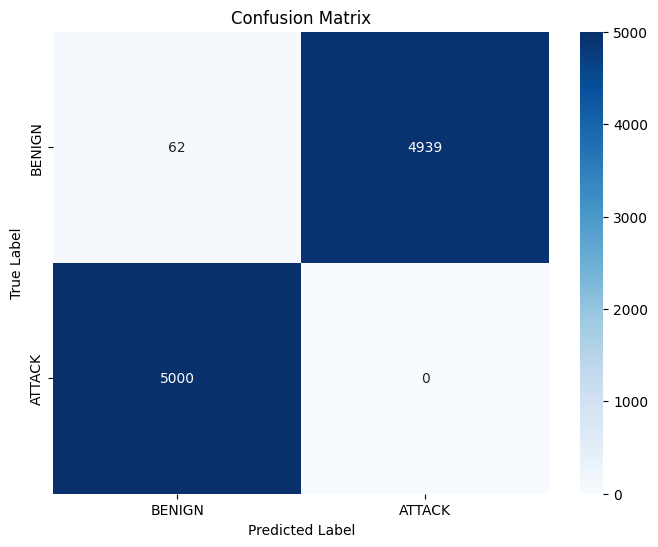

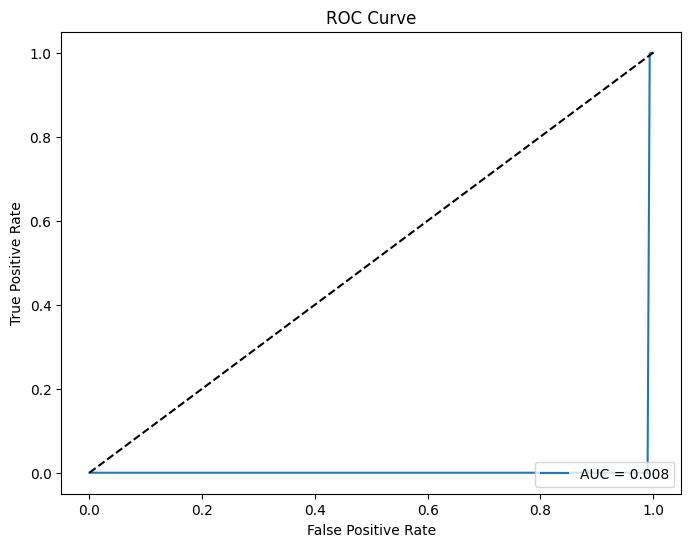

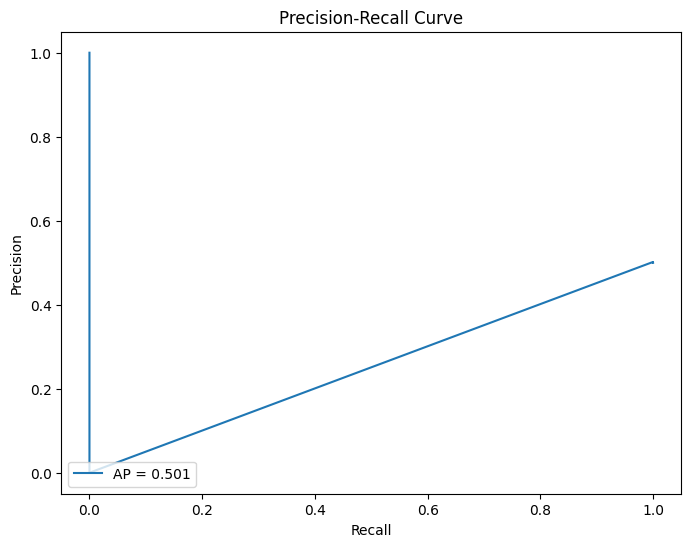

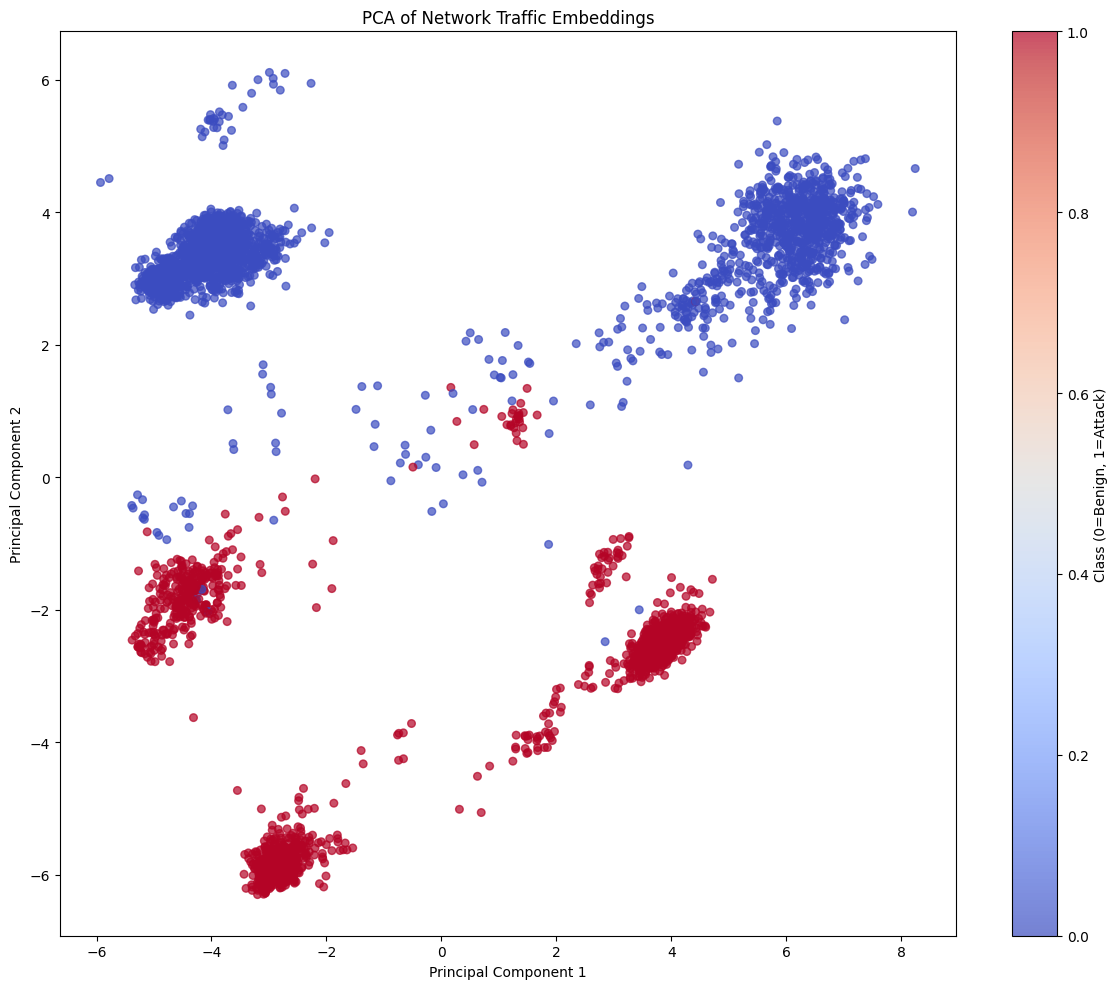

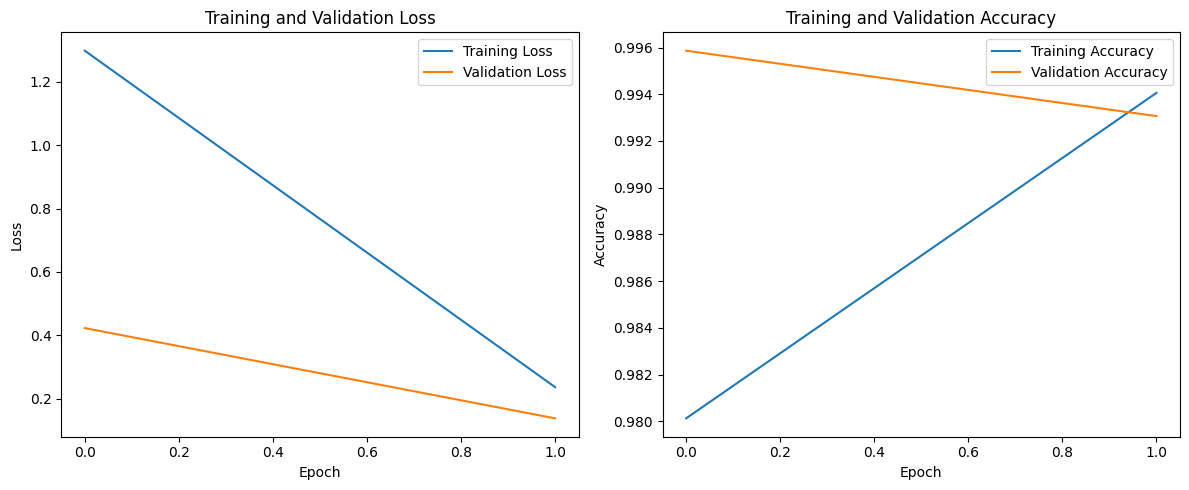

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import seaborn as sns

# Load the datasets
def load_data(embeddings_path, metadata_path):
    """
    Load embeddings and metadata
    """
    # Load embeddings
    print("Loading embeddings...")
    X = np.load(embeddings_path)

    # Load metadata
    print("Loading metadata...")
    metadata = pd.read_csv(metadata_path)

    # Verify data alignment
    print(f"Embeddings shape: {X.shape}")
    print(f"Metadata samples: {metadata.shape[0]}")

    if X.shape[0] != metadata.shape[0]:
        print("Warning: Number of samples in embeddings and metadata don't match!")

    return X, metadata

# Process the data
def process_data(X, metadata, test_size=0.2, validation_size=0.15, multiclass=True):
    """
    Process data and create train/test/validation splits using the actual metadata
    """
    # Get number of samples
    n_samples = X.shape[0]
    print(f"Total samples: {n_samples}")
    print(f"Features per sample: {X.shape[1]}")

    # Analyze label distribution in metadata
    print("\nAttack distribution in dataset:")
    label_counts = metadata['label'].value_counts()
    print(label_counts)

    # Create target variable based on metadata labels
    if multiclass:
        # For multi-class classification (different attack types)
        # Convert string labels to numeric using LabelEncoder
        label_encoder = LabelEncoder()
        y = label_encoder.fit_transform(metadata['label'])

        # Print encoding mapping
        print("\nLabel encoding:")
        for i, label in enumerate(label_encoder.classes_):
            print(f"{label} -> {i}")

        # Check for classes with only one instance (problematic for stratified split)
        class_counts = np.bincount(y)
        rare_classes = np.where(class_counts == 1)[0]

        if len(rare_classes) > 0:
            print("\nWARNING: The following classes have only one sample:")
            for cls_idx in rare_classes:
                print(f"  {label_encoder.classes_[cls_idx]}")

            print("\nConverting to binary classification (BENIGN vs ATTACK) due to rare classes")
            multiclass = False

            # Convert to binary classification
            y_binary = np.zeros(n_samples)
            for i, label in enumerate(metadata['label']):
                if label != "BENIGN":
                    y_binary[i] = 1  # Mark as attack

            y = y_binary
            label_encoder = None  # Reset label encoder for binary mode

    if not multiclass:
        # For binary classification (benign vs attack)
        y = np.zeros(n_samples)
        for i, label in enumerate(metadata['label']):
            if label != "BENIGN":
                y[i] = 1  # Mark as attack
        y = y.astype(np.int32)
        print("Binary y shape:", y.shape)
        print("Binary y unique values:", np.unique(y))
        print("Binary y counts:", np.bincount(y))

    # Print class distribution
    if multiclass and label_encoder is not None:
        for i, label in enumerate(label_encoder.classes_):
            print(f"{label}: {np.sum(y == i)} samples")
    else:
        print(f"Class distribution: {np.sum(y == 0)} benign, {np.sum(y == 1)} attack")

    # Create train/test/validation splits
    try:
        # Try stratified split first
        X_train, X_temp, y_train, y_temp, meta_train, meta_temp = train_test_split(
            X, y, metadata, test_size=test_size + validation_size,
            random_state=42, stratify=y
        )

        # Further split into validation and test sets
        test_ratio = test_size / (test_size + validation_size)
        X_val, X_test, y_val, y_test, meta_val, meta_test = train_test_split(
            X_temp, y_temp, meta_temp, test_size=test_ratio,
            random_state=42, stratify=y_temp
        )

        print("\nUsed stratified sampling for data splits")
    except ValueError as e:
        print(f"\nWarning: {str(e)}")
        print("Falling back to random splitting (non-stratified)")

        # Fall back to non-stratified split
        X_train, X_temp, y_train, y_temp, meta_train, meta_temp = train_test_split(
            X, y, metadata, test_size=test_size + validation_size,
            random_state=42, stratify=None
        )

        test_ratio = test_size / (test_size + validation_size)
        X_val, X_test, y_val, y_test, meta_val, meta_test = train_test_split(
            X_temp, y_temp, meta_temp, test_size=test_ratio,
            random_state=42, stratify=None
        )

    print(f"\nTraining samples: {X_train.shape[0]}")
    print(f"Validation samples: {X_val.shape[0]}")
    print(f"Testing samples: {X_test.shape[0]}")

    # Analyze train/val/test splits by attack type
    for split_name, meta_split in [("Training", meta_train), ("Validation", meta_val), ("Testing", meta_test)]:
        print(f"\n{split_name} set attack distribution:")
        print(meta_split['label'].value_counts())

    # Return all the data splits including metadata splits for further analysis
    return X_train, X_val, X_test, y_train, y_val, y_test, meta_train, meta_val, meta_test, label_encoder

# Build the neural network model
def build_model(input_dim, num_classes=2, dropout_rate=0.4):
    """
    Create a neural network model for classification
    Supports both binary and multi-class classification
    """
    model = Sequential([
        # First hidden layer with dimensionality reduction
        Dense(1024, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Second hidden layer with further reduction
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Third hidden layer
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Fourth hidden layer
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(dropout_rate),

        # Output layer - changes based on binary vs multi-class
        # For binary classification, we use a single output unit with sigmoid
        # For multi-class, we use num_classes output units with softmax
        Dense(num_classes if num_classes > 2 else 1,
              activation='softmax' if num_classes > 2 else 'sigmoid')
    ])

 # Add the appropriate output layer
    if num_classes <= 2:
        print("Building binary classification model (1 output node)")
        model.add(Dense(1, activation='sigmoid'))
        loss_function = 'binary_crossentropy'
        metrics = ['accuracy', tf.keras.metrics.AUC(name='auc')]
    else:
        print(f"Building multi-class model with {num_classes} output nodes")
        model.add(Dense(num_classes, activation='softmax'))
        loss_function = 'sparse_categorical_crossentropy'
        metrics = ['accuracy']

    # Compile the model
    model.compile(
        optimizer='adam',
        loss=loss_function,
        metrics=metrics
    )

    return model

# Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=32, epochs=2):
    """
    Train the neural network model with class weights to handle imbalanced data
    """
    # Detect if we're doing multi-class or binary classification
    # Check the output layer's shape to determine this
    output_layer = model.layers[-1]
    output_units = output_layer.get_config()['units']
    is_multiclass = output_units > 1

    # Calculate class weights to handle imbalanced data
    if is_multiclass:
        # For multi-class, get class distribution
        unique_classes, class_counts = np.unique(y_train, return_counts=True)
        # Create class weights dictionary
        total_samples = len(y_train)
        class_weights = {}
        for i, cls in enumerate(unique_classes):
            # Inverse frequency weighting
            class_weights[int(cls)] = total_samples / (len(unique_classes) * class_counts[i])
        print("Class weights:", class_weights)
    else:
        # For binary classification
        neg, pos = np.bincount(y_train.astype(int))
        total = neg + pos
        # Compute balanced class weights (sklearn style)
        class_weights = {0: total/(2.0*neg), 1: total/(2.0*pos)}
        print("Class weights:", class_weights)

    # Callbacks for early stopping and model checkpointing
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    model_checkpoint = ModelCheckpoint(
        'best_model.h5',
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        verbose=1
    )

    # Train the model with class weights
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, model_checkpoint],
        class_weight=class_weights,
        verbose=1
    )

    return model, history

# Evaluate the model
def evaluate_model(model, X_test, y_test, label_encoder=None):
    """
    Evaluate the neural network model
    Supports both binary and multi-class classification
    """
    print(f"DEBUG - X_test shape: {X_test.shape}")
    print(f"DEBUG - y_test shape: {y_test.shape if hasattr(y_test, 'shape') else len(y_test)}")
    # Get predictions
    y_pred_prob = model.predict(X_test)
    print(f"DEBUG - y_pred_prob shape: {y_pred_prob.shape}")
    print(f"Sample of prediction probabilities: {y_pred_prob[:5]}")
    # print(f"Prediction distribution: {np.bincount(y_pred_prob.astype(int))}")
    print(f"Actual label distribution: {np.bincount(y_test.astype(int))}")

    # Handle binary vs multi-class cases
    is_multiclass = label_encoder is not None

    if is_multiclass:
        # For multi-class, get class with highest probability
        y_pred = np.argmax(y_pred_prob, axis=1)
        print(f"DEBUG - y_pred shape: {y_pred.shape}")

        # Get class names for better reporting
        class_names = label_encoder.classes_

        # Calculate and display evaluation metrics
        print("\nMulti-class Classification Report:")
        print(classification_report(y_test, y_pred, target_names=class_names))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=class_names, yticklabels=class_names)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('confusion_matrix.png')

    else:
         # Binary classification
        # Fix for shape mismatch - ensure y_pred_prob has correct dimensions
        if len(y_pred_prob.shape) > 1 and y_pred_prob.shape[0] != X_test.shape[0]:
            print(f"WARNING: Prediction shape mismatch. Reshaping predictions array...")
            # Reshape to match expected size
            y_pred_prob = y_pred_prob.reshape(X_test.shape[0], -1)
            print(f"After reshape: {y_pred_prob.shape}")

        # Handle different output formats from the model
        if len(y_pred_prob.shape) > 1:
            if y_pred_prob.shape[1] > 1:  # Multiple outputs per sample
                print("Multiple outputs detected, using first column for binary prediction")
                y_pred_prob = y_pred_prob[:, 0]
            else:  # Single output dimension, but 2D array
                y_pred_prob = y_pred_prob.flatten()

        y_pred = (y_pred_prob > 0.5).astype(int)
        print(f"DEBUG - Final y_pred shape: {y_pred.shape}")
        # Calculate and display evaluation metrics
        print("\nBinary Classification Report:")
        print(classification_report(y_test, y_pred, target_names=['BENIGN', 'ATTACK']))

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['BENIGN', 'ATTACK'], yticklabels=['BENIGN', 'ATTACK'])
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.savefig('confusion_matrix.png')

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.3f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig('roc_curve.png')

        # Precision-Recall curve (good for imbalanced datasets)
        precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
        avg_precision = average_precision_score(y_test, y_pred_prob)

        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'AP = {avg_precision:.3f}')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='lower left')
        plt.savefig('precision_recall_curve.png')

    return y_pred, y_pred_prob

# Dimensionality reduction for visualization
def visualize_data(X, y, metadata=None, label_encoder=None):
    """
    Apply dimensionality reduction and visualize the data
    """
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    # Sample if the dataset is very large (for faster processing)
    max_samples = 5000
    if X.shape[0] > max_samples:
        print(f"Sampling {max_samples} points for visualization...")
        sample_indices = np.random.choice(X.shape[0], max_samples, replace=False)
        X_sample = X[sample_indices]
        y_sample = y[sample_indices]
        if metadata is not None:
            metadata_sample = metadata.iloc[sample_indices].reset_index(drop=True)
    else:
        X_sample = X
        y_sample = y
        metadata_sample = metadata

    # Apply PCA for dimensionality reduction
    print("Applying PCA for visualization...")
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_sample)

    # Create a more informative visualization
    plt.figure(figsize=(12, 10))

    # Determine if we're using multi-class or binary classification
    if label_encoder is not None:
        # Multi-class visualization with actual attack names
        classes = label_encoder.classes_
        # Use a categorical colormap
        cmap = plt.cm.get_cmap('tab10', len(classes))
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample, cmap=cmap, alpha=0.7, s=30)

        # Add a legend with actual attack names
        legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                     markerfacecolor=cmap(i), markersize=10,
                                     label=classes[i])
                          for i in range(len(classes))]
        plt.legend(handles=legend_elements, title="Attack Types", loc="best")
    else:
        # Binary classification (benign vs attack)
        scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_sample,
                             cmap='coolwarm', alpha=0.7, s=30)
        plt.colorbar(scatter, label='Class (0=Benign, 1=Attack)')

    plt.title('PCA of Network Traffic Embeddings')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.tight_layout()
    plt.savefig('pca_visualization.png')

    # Print explained variance
    explained_variance = pca.explained_variance_ratio_
    print(f"Explained variance by 2 principal components: {sum(explained_variance)*100:.2f}%")
    print(f"Component 1: {explained_variance[0]*100:.2f}%")
    print(f"Component 2: {explained_variance[1]*100:.2f}%")

    # If explained variance is low, try t-SNE as well
    if sum(explained_variance) < 0.5:
        print("\nPCA explains low variance. Trying t-SNE for better visualization...")

        # Apply t-SNE
        tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
        X_tsne = tsne.fit_transform(X_sample)

        plt.figure(figsize=(12, 10))

        if label_encoder is not None:
            # Multi-class t-SNE visualization
            scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample, cmap=cmap, alpha=0.7, s=30)
            plt.legend(handles=legend_elements, title="Attack Types", loc="best")
        else:
            # Binary t-SNE visualization
            scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_sample,
                                 cmap='coolwarm', alpha=0.7, s=30)
            plt.colorbar(scatter, label='Class (0=Benign, 1=Attack)')

        plt.title('t-SNE of Network Traffic Embeddings')
        plt.xlabel('t-SNE Component 1')
        plt.ylabel('t-SNE Component 2')

# Anomaly detection approach
def anomaly_detection_model(X_benign, X_test, y_test=None, metadata_test=None, label_encoder=None):
    """
    Alternative approach: Autoencoder for anomaly detection
    This is useful when you have mostly benign data and want to detect anomalies
    """
    from tensorflow.keras.layers import Input, Dense
    from tensorflow.keras.models import Model

    # Build autoencoder
    input_dim = X_benign.shape[1]

    # Encoder
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(1024, activation='relu')(input_layer)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(512, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(256, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)
    encoded = Dense(128, activation='relu')(encoded)
    encoded = BatchNormalization()(encoded)

    # Middle layer (bottleneck)
    bottleneck = Dense(64, activation='relu')(encoded)

    # Decoder
    decoded = Dense(128, activation='relu')(bottleneck)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(256, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(512, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    decoded = Dense(1024, activation='relu')(decoded)
    decoded = BatchNormalization()(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    # Autoencoder model
    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    autoencoder.compile(optimizer='adam', loss='mse')

    # Print model summary
    autoencoder.summary()

    # Train on benign data only
    print(f"Training autoencoder on {X_benign.shape[0]} benign samples...")
    autoencoder.fit(
        X_benign, X_benign,
        batch_size=32,
        epochs=20,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5, restore_best_weights=True)],
        verbose=1
    )

    # Calculate reconstruction error on test data
    print(f"Calculating reconstruction errors on {X_test.shape[0]} test samples...")
    reconstructions = autoencoder.predict(X_test)
    mse = np.mean(np.power(X_test - reconstructions, 2), axis=1)

    # Plot error distribution
    plt.figure(figsize=(12, 6))

    # If we have labels, color the histogram by class
    if y_test is not None and label_encoder is not None:
        # For multi-class, we need to identify benign vs attacks
        if len(label_encoder.classes_) > 2:
            benign_idx = np.where(label_encoder.classes_ == "BENIGN")[0][0]
            y_binary = np.where(y_test == benign_idx, 0, 1)  # 0 for benign, 1 for attacks

            # Plot histograms for benign and attack classes
            benign_errors = mse[y_binary == 0]
            attack_errors = mse[y_binary == 1]

            plt.hist(benign_errors, bins=50, alpha=0.5, label="BENIGN", color="blue")
            plt.hist(attack_errors, bins=50, alpha=0.5, label="ATTACK", color="red")
            plt.legend()
        else:
            # Binary classification
            benign_errors = mse[y_test == 0]
            attack_errors = mse[y_test == 1]

            plt.hist(benign_errors, bins=50, alpha=0.5, label="BENIGN", color="blue")
            plt.hist(attack_errors, bins=50, alpha=0.5, label="ATTACK", color="red")
            plt.legend()
    else:
        # Simple histogram without class information
        plt.hist(mse, bins=50, alpha=0.7)

    # Calculate threshold (95th percentile of errors)
    threshold = np.percentile(mse, 95)
    plt.axvline(threshold, color='g', linestyle='--',
                label=f'Threshold (95th percentile): {threshold:.4f}')

    plt.title('Reconstruction Error Distribution')
    plt.xlabel('Reconstruction Error (MSE)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig('reconstruction_error.png')

    # Make predictions (above threshold = anomaly)
    anomaly_predictions = (mse > threshold).astype(int)

    # If we have ground truth labels, evaluate the anomaly detection
    if y_test is not None:
        if label_encoder is not None and len(label_encoder.classes_) > 2:
            # Convert multi-class to binary (benign vs attack) for evaluation
            benign_idx = np.where(label_encoder.classes_ == "BENIGN")[0][0]
            y_binary = np.where(y_test == benign_idx, 0, 1)

            print("\nAnomaly Detection Evaluation:")
            print(classification_report(y_binary, anomaly_predictions,
                                      target_names=["BENIGN", "ATTACK"]))

            # Per-attack-type analysis
            if metadata_test is not None:
                print("\nAnomaly Detection Performance by Attack Type:")
                for attack_type in metadata_test['label'].unique():
                    attack_indices = metadata_test['label'] == attack_type
                    if sum(attack_indices) > 0:
                        attack_count = sum(attack_indices)
                        detected = sum(anomaly_predictions[attack_indices.values] == 1)
                        print(f"{attack_type}: {detected}/{attack_count} " +
                              f"({detected/attack_count*100:.1f}% detection rate)")
        else:
            # Binary classification evaluation
            print("\nAnomaly Detection Evaluation:")
            print(classification_report(y_test, anomaly_predictions,
                                      target_names=["BENIGN", "ATTACK"]))

    return anomaly_predictions, mse, threshold

# Main execution flow
def main():
    # File paths for the new combined dataset    
    embeddings_path = "finetuned-embeddings-1_1-split/combined_embeddings.npy"
    metadata_path = "finetuned-embeddings-1_1-split/combined_metadata.csv"

    # Load data
    X, metadata = load_data(embeddings_path, metadata_path)

    # Check if we want multi-class (different attack types) or binary classification
    print("\nDetecting unique attack types in the dataset...")
    unique_attacks = metadata['label'].unique()
    print(f"Found {len(unique_attacks)} unique labels: {unique_attacks}")

    # Default to multi-class if we have more than 2 classes
    use_multiclass = len(unique_attacks) > 2
    if len(unique_attacks) > 2:
        print("Multiple attack types detected. Using multi-class classification.")
    else:
        print("Only two classes detected. Using binary classification.")

    # Process data with the actual metadata
    X_train, X_val, X_test, y_train, y_val, y_test, meta_train, meta_val, meta_test, label_encoder = process_data(
        X, metadata, multiclass=use_multiclass
    )

    # Build and train model
    print("\nBuilding and training neural network...")
    num_classes = len(unique_attacks) if use_multiclass else 2
    model = build_model(input_dim=X.shape[1], num_classes=num_classes)
    model.summary()

    # Train the model
    trained_model, history = train_model(model, X_train, y_train, X_val, y_val)

    # Evaluate model
    print("\nEvaluating model...")
    y_pred, y_pred_prob = evaluate_model(trained_model, X_test, y_test, label_encoder)

    # Visualize data with actual class labels for better interpretation
    print("\nGenerating data visualizations...")
    all_X = np.vstack([X_train, X_val, X_test])
    all_y = np.hstack([y_train, y_val, y_test])
    all_meta = pd.concat([meta_train, meta_val, meta_test], ignore_index=True)
    visualize_data(all_X, all_y, all_meta, label_encoder)

    # Plot training history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    if 'auc' in history.history:
        # For binary classification
        plt.subplot(1, 2, 2)
        plt.plot(history.history['auc'], label='Training AUC')
        plt.plot(history.history['val_auc'], label='Validation AUC')
        plt.title('Training and Validation AUC')
        plt.xlabel('Epoch')
        plt.ylabel('AUC')
        plt.legend()
    else:
        # For multi-class
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.savefig('training_history.png')

    # # Also demonstrate the anomaly detection approach as an alternative
    # print("\nDemonstrating anomaly detection approach...")

    # # For anomaly detection, we only use BENIGN samples for training
    # if use_multiclass and label_encoder is not None:
    #     benign_class_idx = np.where(label_encoder.classes_ == "BENIGN")[0][0]
    #     benign_indices = np.where(all_y == benign_class_idx)[0]
    # else:
    #     benign_indices = np.where(all_y == 0)[0]

    # X_benign = all_X[benign_indices]
    # print(f"Using {len(X_benign)} benign samples for anomaly detection model training")

    # # Train and evaluate anomaly detection model
    # anomaly_pred, reconstruction_errors, threshold = anomaly_detection_model(
    #     X_benign, X_test, y_test, meta_test, label_encoder
    # )

    print("Neural network training and evaluation complete!")

if __name__ == "__main__":
    main()



In [ ]:

embeddings_path = "finetuned-embeddings-1_1-splits/combined_embeddings.npy"
metadata_path = "finetuned-embeddings-1_1-splits/combined_metadata.csv"

X, metadata = load_data(embeddings_path, metadata_path)
print(f"X shape: {X.shape}")
print(f"metadata shape: {metadata.shape}")

Loading embeddings...
Loading metadata...
Embeddings shape: (18000, 8192)
Metadata samples: 18000
X shape: (18000, 8192)
metadata shape: (18000, 3)


In [ ]:
##balanced

In [ ]:
import numpy as np
import pandas as pd
import os

def view_npy_and_csv_dimensions(npy_file_path, csv_file_path=None):
    """
    View the dimensions and basic information of an NPY file and its associated CSV metadata.

    Parameters:
    -----------
    npy_file_path : str
        Path to the .npy file
    csv_file_path : str, optional
        Path to the associated CSV metadata file. If None, will try to find a CSV
        with the same name as the NPY file.
    """
    # Check if NPY file exists
    if not os.path.exists(npy_file_path):
        print(f"Error: NPY file '{npy_file_path}' not found.")
        return

    # Load and display NPY file info
    try:
        # Load the array
        array_data = np.load(npy_file_path, allow_pickle=True)

        print("\n" + "="*50)
        print(f"NPY FILE: {npy_file_path}")
        print("="*50)

        # Display basic information
        print(f"Array shape: {array_data.shape}")
        print(f"Array dimensions: {array_data.ndim}")
        print(f"Data type: {array_data.dtype}")
        print(f"Size (elements): {array_data.size}")
        print(f"Memory size: {array_data.nbytes / (1024*1024):.2f} MB")

        # Display a sample of the data if not too large
        if array_data.size < 10:
            print("\nArray contents:")
            print(array_data)
        else:
            print("\nFirst few elements:")
            if array_data.ndim == 1:
                print(array_data[:5])
            else:
                print(array_data[:2])

    except Exception as e:
        print(f"Error loading NPY file: {str(e)}")

    # Handle CSV file
    if csv_file_path is None:
        # Try to find a CSV with the same base name
        base_name = os.path.splitext(npy_file_path)[0]
        potential_csv = base_name + ".csv"
        if os.path.exists(potential_csv):
            csv_file_path = potential_csv
            print(f"\nFound associated CSV file: {potential_csv}")

    if csv_file_path and os.path.exists(csv_file_path):
        try:
            # Load the CSV
            df = pd.read_csv(csv_file_path)

            print("\n" + "="*50)
            print(f"CSV METADATA: {csv_file_path}")
            print("="*50)

            # Display basic information
            print(f"Rows: {df.shape[0]}")
            print(f"Columns: {df.shape[1]}")
            print(f"Memory usage: {df.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")

            # Display column information
            print("\nColumns and data types:")
            for col, dtype in zip(df.columns, df.dtypes):
                print(f"  - {col}: {dtype}")

            # Display a few rows
            print("\nFirst few rows:")
            print(df.head(3).to_string())

        except Exception as e:
            print(f"Error loading CSV file: {str(e)}")
    elif csv_file_path:
        print(f"\nCSV file '{csv_file_path}' not found.")
    else:
        print("\nNo associated CSV file specified or found.")

# Example usage:
if __name__ == "__main__":
    # Example 1: Specify both files
    view_npy_and_csv_dimensions("combined_embeddings.npy", "combined_metadata.csv")

    # Example 2: Only specify NPY file, and let the function find a CSV with the same name
    # view_npy_and_csv_dimensions("data.npy")


NPY FILE: combined_embeddings.npy
Array shape: (18000, 8192)
Array dimensions: 2
Data type: float32
Size (elements): 147456000
Memory size: 562.50 MB

First few elements:
[[-0.30735764  0.00717924  0.39611045 ...  0.9278606   0.94753104
  -1.4166973 ]
 [-0.5882837  -0.05928049  0.46860275 ...  1.1192337   0.5966306
  -1.5431002 ]]

CSV METADATA: combined_metadata.csv
Rows: 18000
Columns: 3
Memory usage: 2.46 MB

Columns and data types:
  - index: int64
  - label: object
  - file: object

First few rows:
    index   label        file
0  256723  BENIGN  friday.csv
1   35292  BENIGN  friday.csv
2  174928  BENIGN  friday.csv


Running in Google Colab
Checking for GPU availability...
TensorFlow version: 2.18.0
Num GPUs Available:  1
GPU is available and will be used
Mixed precision policy: mixed_float16
Setting paths to the specified locations...
Using embeddings file: /content/combined_embeddings.npy
Using metadata file: /content/combined_metadata.csv
✓ Embeddings file found at /content/combined_embeddings.npy
✓ Metadata file found at /content/combined_metadata.csv
Loading embeddings from /content/combined_embeddings.npy...
Loading metadata from /content/combined_metadata.csv...
Loaded 18000 samples with 8192 features
Label distribution: {'BENIGN': np.int64(10500), 'Botnet': np.int64(7), 'Botnet - Attempted': np.int64(47), 'DDoS': np.int64(949), 'DoS GoldenEye': np.int64(72), 'DoS GoldenEye - Attempted': np.int64(1), 'DoS Hulk': np.int64(1330), 'DoS Hulk - Attempted': np.int64(5), 'DoS Slowhttptest': np.int64(10), 'DoS Slowhttptest - Attempted': np.int64(31), 'DoS Slowloris': np.int64(31), 'DoS Slowloris - A

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,329,793 (66.11 MB)

 Trainable params: 17,325,057 (66.09 MB)

 Non-trainable params: 4,736 (18.50 KB)

Training model...
Starting training with batch size 64 on GPU
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.9661 - auc_2: 0.9905 - loss: 0.0849 - precision_2: 0.9472 - recall_2: 0.9766
Epoch 1: val_loss improved from inf to 6.58094, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 76ms/step - accuracy: 0.9662 - auc_2: 0.9905 - loss: 0.0847 - precision_2: 0.9474 - recall_2: 0.9767 - val_accuracy: 0.5833 - val_auc_2: 0.5000 - val_loss: 6.5809 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00 - learning_rate: 0.0010
Training completed in 0 minutes and 20.03 seconds
Evaluating model...
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5867 - auc_2: 0.5000 - loss: 6.5665 - precision_2: 0.0000e+00 - recall_2: 0.0000e+00
Test loss: 6.6173
Test accuracy: 0.5833
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
Test accuracy: 0.5833
ROC AUC: 0.5200

Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.74      2100
           1       0.00      0.00      0.00      1500

    accuracy                           0.58      3600
   macro avg       0.29      0.50      0.37      3600
weighted avg       0.34      0.58      0.43      3600



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Results visualization saved to: /content/network_attack_classifier_results.png


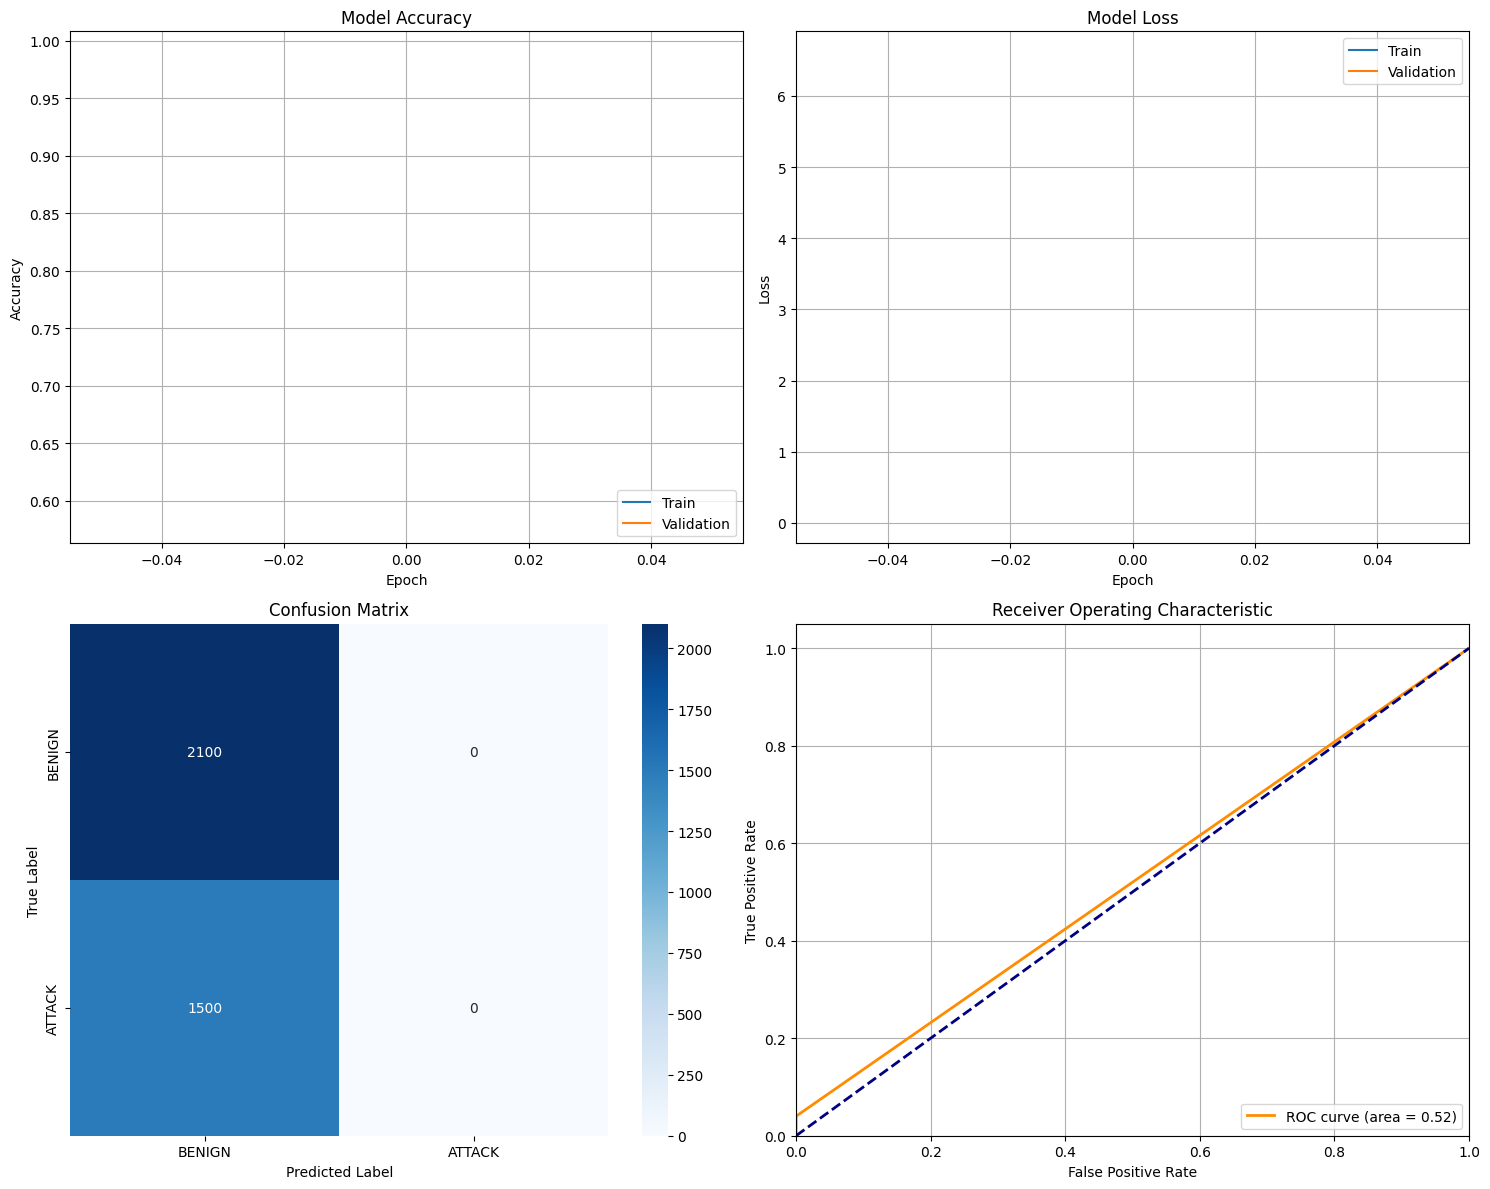

Model saved to: /content/network_attack_classifier_model.h5
Complete! Model has been trained, evaluated, and saved to /content directory.

Analyzing performance by attack type...
563/563 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


<ipython-input-4-4f4c80d951dd>:338: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  label_accuracy = metadata_df.groupby('label').apply(



Accuracy by attack type:
Botnet: 0.0000
Botnet - Attempted: 0.0000
DDoS: 0.0000
DoS GoldenEye: 0.0000
DoS Hulk: 0.0000
DoS GoldenEye - Attempted: 0.0000
DoS Hulk - Attempted: 0.0000
DoS Slowhttptest: 0.0000
FTP-Patator: 0.0000
DoS Slowhttptest - Attempted: 0.0000
DoS Slowloris: 0.0000
DoS Slowloris - Attempted: 0.0000
Infiltration: 0.0000
FTP-Patator - Attempted: 0.0000
Infiltration - Portscan: 0.0000
Portscan: 0.0000
Web Attack - Brute Force - Attempted: 0.0000
SSH-Patator: 0.0000
SSH-Patator - Attempted: 0.0000
Web Attack - Brute Force: 0.0000
Web Attack - XSS - Attempted: 0.0000
Web Attack - SQL Injection - Attempted: 0.0000
BENIGN: 1.0000
Attack type analysis saved to: /content/accuracy_by_attack_type.png


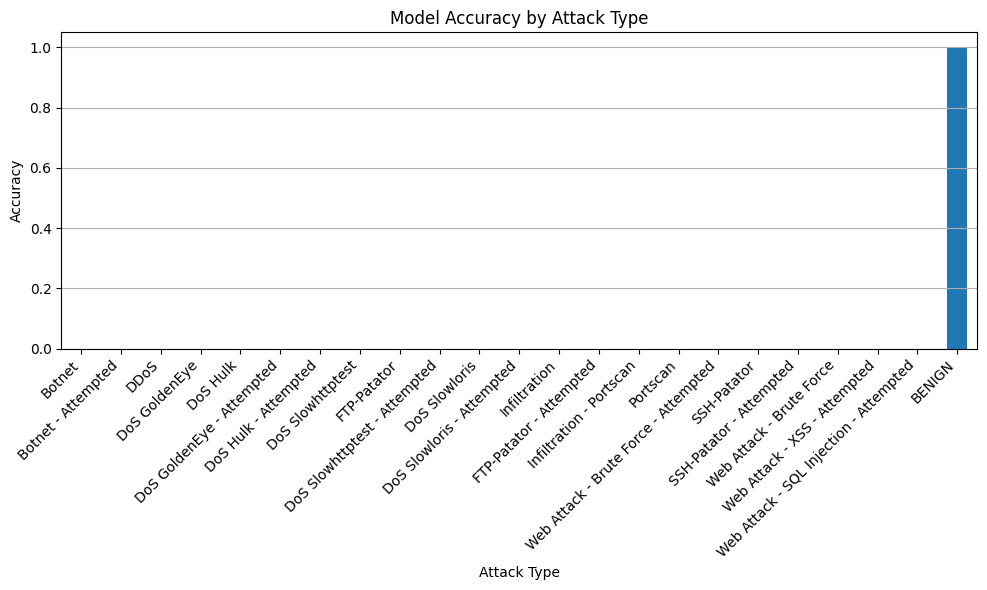

In [ ]:
# Network Attack Classification using Deep Learning
# GPU-accelerated on Google Colab

# Install any additional packages if needed
# !pip install -q tensorflow-gpu

# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import time
import os
# Import drive only if we need it
try:
    from google.colab import drive, files
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab")

# 2. Check for GPU availability
print("Checking for GPU availability...")
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available and will be used")
    # Set memory growth to avoid allocating all GPU memory at once
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision training for faster performance
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision policy:", policy.name)
else:
    print("No GPU available, using CPU instead")

# 3. Mount Google Drive (optional - commented out as we're working in /content)
# print("Mounting Google Drive...")
# drive.mount('/content/drive')

# 4. Set the file paths to your specific locations
print("Setting paths to the specified locations...")
embeddings_path = 'finetuned-embeddings-1_1-split/combined_embeddings.npy'
metadata_path = 'finetuned-embeddings-1_1-split/combined_metadata.csv'  # Note: Changed from .npy to .csv based on your earlier output

print(f"Using embeddings file: {embeddings_path}")
print(f"Using metadata file: {metadata_path}")

# Check if files exist
if os.path.exists(embeddings_path):
    print(f"✓ Embeddings file found at {embeddings_path}")
else:
    print(f"❌ Warning: Embeddings file not found at {embeddings_path}")

if os.path.exists(metadata_path):
    print(f"✓ Metadata file found at {metadata_path}")
else:
    print(f"❌ Warning: Metadata file not found at {metadata_path}")


# 6. Load and prepare data
def load_data(embeddings_path, metadata_path):
    """Load embeddings and metadata files"""
    print(f"Loading embeddings from {embeddings_path}...")
    X = np.load(embeddings_path)

    print(f"Loading metadata from {metadata_path}...")
    metadata_df = pd.read_csv(metadata_path)

    # Encode labels (BENIGN as 0, any attack type as 1)
    metadata_df['encoded_label'] = (metadata_df['label'] != 'BENIGN').astype(int)
    y = metadata_df['encoded_label'].values

    print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
    unique_labels, counts = np.unique(metadata_df['label'], return_counts=True)
    label_counts = dict(zip(unique_labels, counts))
    print(f"Label distribution: {label_counts}")
    print(f"Binary label distribution: {dict(zip(*np.unique(y, return_counts=True)))}")

    return X, y, metadata_df

# 7. Create dataset splits
def create_dataset_splits(X, y, test_size=0.2, val_size=0.25):
    """Create train, validation, and test splits"""
    # First split: training+validation and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=42
    )

    # Second split: training and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

# 8. Build the model
def build_model(input_dim, reduction_factor=4):
    """Build a neural network for binary classification"""
    # Calculate reduced dimension size
    reduced_dim = input_dim // reduction_factor

    model = Sequential([
        # First, reduce dimensions with a bottleneck layer
        Dense(reduced_dim, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),

        # Middle layers
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer for binary classification
        Dense(1, activation='sigmoid')
    ])

    # Compile model with appropriate mixed precision dtype
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )

    return model

# 9. Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=1):
    """Train the neural network model"""
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    # TensorBoard callback
    log_dir = "./content/logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )

    # Model checkpoint
    checkpoint_callback = ModelCheckpoint(
        './content/best_model_checkpoint.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Create TensorFlow Dataset for better GPU utilization
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Train the model
    print(f"Starting training with batch size {batch_size} on {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'}")
    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback],
        verbose=1
    )

    training_time = time.time() - start_time
    minutes, seconds = divmod(training_time, 60)
    print(f"Training completed in {int(minutes)} minutes and {seconds:.2f} seconds")

    return history

# 10. Evaluate the model
def evaluate_model(model, X_test, y_test):
    """Evaluate the model on test data"""
    # Convert to TensorFlow Dataset for efficient processing
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

    # Get model evaluation on test dataset
    test_results = model.evaluate(test_ds, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(test_ds)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    print(f"Test accuracy: {acc:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    results = {
        'accuracy': acc,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': cm,
        'fpr': fpr,
        'tpr': tpr,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred
    }

    return results

# 11. Plot results
def plot_results(history, results):
    """Plot training history and evaluation results"""
    # Create a figure with multiple subplots
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))

    # Plot training & validation accuracy
    axs[0, 0].plot(history.history['accuracy'])
    axs[0, 0].plot(history.history['val_accuracy'])
    axs[0, 0].set_title('Model Accuracy')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_xlabel('Epoch')
    axs[0, 0].legend(['Train', 'Validation'], loc='lower right')
    axs[0, 0].grid(True)

    # Plot training & validation loss
    axs[0, 1].plot(history.history['loss'])
    axs[0, 1].plot(history.history['val_loss'])
    axs[0, 1].set_title('Model Loss')
    axs[0, 1].set_ylabel('Loss')
    axs[0, 1].set_xlabel('Epoch')
    axs[0, 1].legend(['Train', 'Validation'], loc='upper right')
    axs[0, 1].grid(True)

    # Plot confusion matrix
    cm = results['confusion_matrix']
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[1, 0])
    axs[1, 0].set_title('Confusion Matrix')
    axs[1, 0].set_ylabel('True Label')
    axs[1, 0].set_xlabel('Predicted Label')
    axs[1, 0].set_xticklabels(['BENIGN', 'ATTACK'])
    axs[1, 0].set_yticklabels(['BENIGN', 'ATTACK'])

    # Plot ROC curve
    axs[1, 1].plot(results['fpr'], results['tpr'], color='darkorange', lw=2,
                  label=f'ROC curve (area = {results["roc_auc"]:.2f})')
    axs[1, 1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    axs[1, 1].set_xlim([0.0, 1.0])
    axs[1, 1].set_ylim([0.0, 1.05])
    axs[1, 1].set_xlabel('False Positive Rate')
    axs[1, 1].set_ylabel('True Positive Rate')
    axs[1, 1].set_title('Receiver Operating Characteristic')
    axs[1, 1].legend(loc="lower right")
    axs[1, 1].grid(True)

    plt.tight_layout()
    plt.savefig('./content/network_attack_classifier_results.png')
    print("Results visualization saved to: /.content/network_attack_classifier_results.png")
    plt.show()

# 12. Save model
def save_model(model, path='./content/network_attack_classifier_model.h5'):
    """Save the trained model to the content directory"""
    model.save(path)
    print(f"Model saved to: {path}")

# 13. Main execution
# Load data
X, y, metadata_df = load_data(embeddings_path, metadata_path)

# Create dataset splits
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset_splits(X, y)

# Build the model
print("Building model...")
model = build_model(input_dim=X.shape[1])
model.summary()

# Train the model
print("Training model...")
history = train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=1)

# Evaluate the model
print("Evaluating model...")
results = evaluate_model(model, X_test, y_test)

# Plot results
plot_results(history, results)

# Save the model
save_model(model)

print("Complete! Model has been trained, evaluated, and saved to ./content directory.")

# 14. Optional: Analyze model performance on specific attack types
print("\nAnalyzing performance by attack type...")
# Get predictions for all data
all_preds = model.predict(X).flatten() > 0.5

# Merge predictions with original metadata
metadata_df['predicted'] = all_preds

# Calculate accuracy per attack type
label_accuracy = metadata_df.groupby('label').apply(
    lambda x: accuracy_score(x['encoded_label'], x['predicted'])
).sort_values()

print("\nAccuracy by attack type:")
for label, acc in label_accuracy.items():
    print(f"{label}: {acc:.4f}")

# Create visualization of performance by attack type
plt.figure(figsize=(10, 6))
label_accuracy.plot(kind='bar')
plt.title('Model Accuracy by Attack Type')
plt.ylabel('Accuracy')
plt.xlabel('Attack Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('./content/accuracy_by_attack_type.png')
print("Attack type analysis saved to: ./content/accuracy_by_attack_type.png")
plt.show()


In [ ]:
## balanced multiclass

Running in Google Colab
Checking for GPU availability...
TensorFlow version: 2.18.0
Num GPUs Available:  1
GPU is available and will be used
Mixed precision policy: mixed_float16
Setting paths to the specified locations...
Using embeddings file: /content/combined_embeddings.npy
Using metadata file: /content/combined_metadata.csv
✓ Embeddings file found at /content/combined_embeddings.npy
✓ Metadata file found at /content/combined_metadata.csv
Loading embeddings from /content/combined_embeddings.npy...
Loading metadata from /content/combined_metadata.csv...
Preparing for multi-class classification...
Loaded 18000 samples with 8192 features
Detected 23 unique classes: ['BENIGN' 'Botnet' 'Botnet - Attempted' 'DDoS' 'DoS GoldenEye'
 'DoS GoldenEye - Attempted' 'DoS Hulk' 'DoS Hulk - Attempted'
 'DoS Slowhttptest' 'DoS Slowhttptest - Attempted' 'DoS Slowloris'
 'DoS Slowloris - Attempted' 'FTP-Patator' 'FTP-Patator - Attempted'
 'Infiltration' 'Infiltration - Portscan' 'Portscan' 'SSH-Patat

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_28 (Dense)                │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,907,735 (68.31 MB)

 Trainable params: 17,902,359 (68.29 MB)

 Non-trainable params: 5,376 (21.00 KB)

Training model for EXACTLY 1 epoch...
Starting training with batch size 64 on GPU
Training for EXACTLY 1 epoch - early stopping is disabled for single-epoch training
169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step - accuracy: 0.7851 - loss: 0.9570 - val_accuracy: 0.6343 - val_loss: 3.5332
Training completed in 0 minutes and 13.15 seconds
Evaluating model...
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6312 - loss: 3.5478
Test loss: 3.5334
Test accuracy: 0.6341
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step

Test set contains 19 out of 23 classes
Classes in test set: ['BENIGN', 'Botnet', 'Botnet - Attempted', 'DDoS', 'DoS GoldenEye', 'DoS Hulk', 'DoS Hulk - Attempted', 'DoS Slowhttptest', 'DoS Slowhttptest - Attempted', 'DoS Slowloris', 'DoS Slowloris - Attempted', 'FTP-Patator', 'FTP-Patator - Attempted', 'Infiltration - Portscan', 'Portscan', 'SSH-Patator', 'SSH-Patator - Attempted', 'Web Attack - Brute Force - Attempted', 'Web Attack - XSS - Attempted']

Classification Report:
           

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

Training history saved to: /content/network_attack_training_history.png


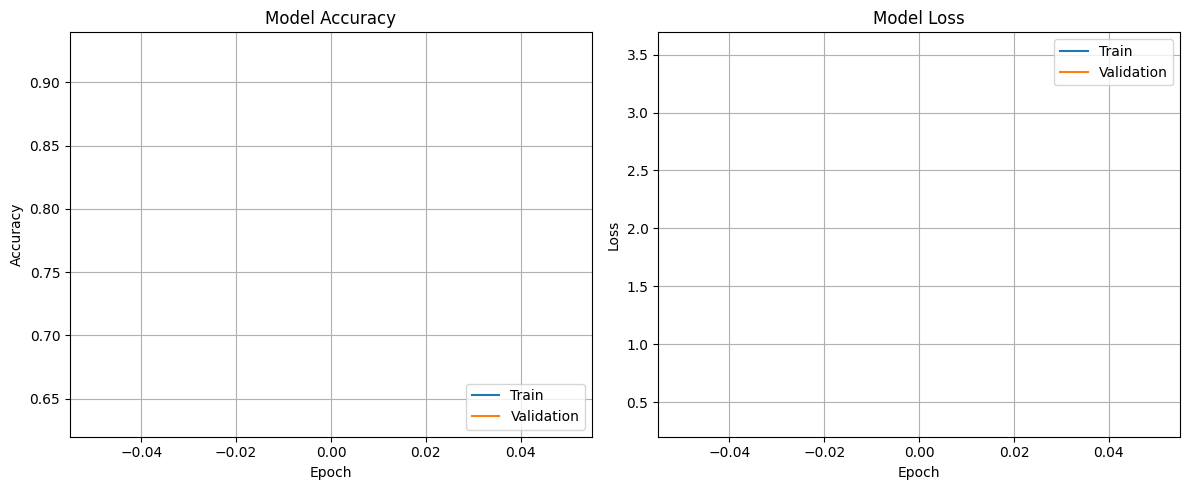

Confusion matrix saved to: /content/network_attack_confusion_matrix.png


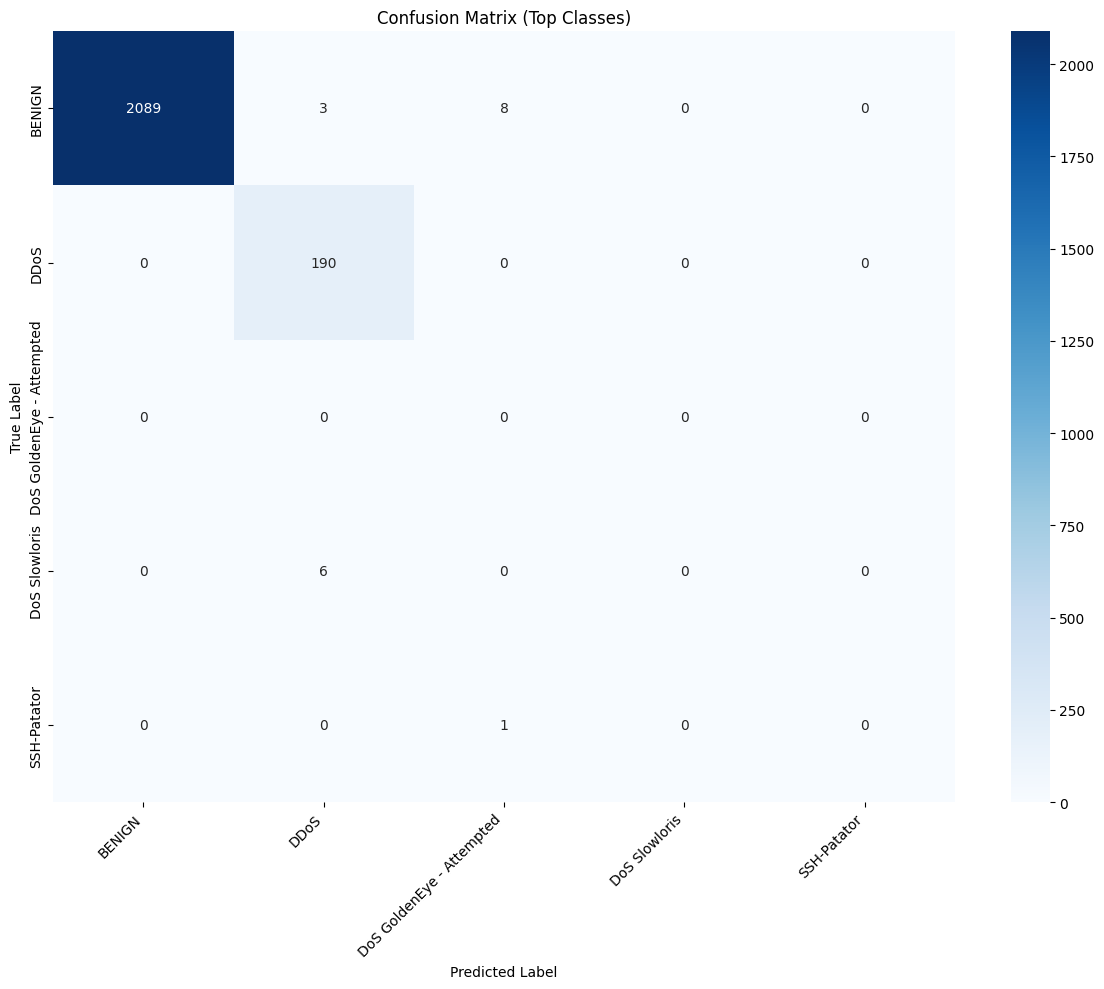

Per-class metrics saved to: /content/network_attack_class_metrics.png


<Figure size 1200x800 with 0 Axes>

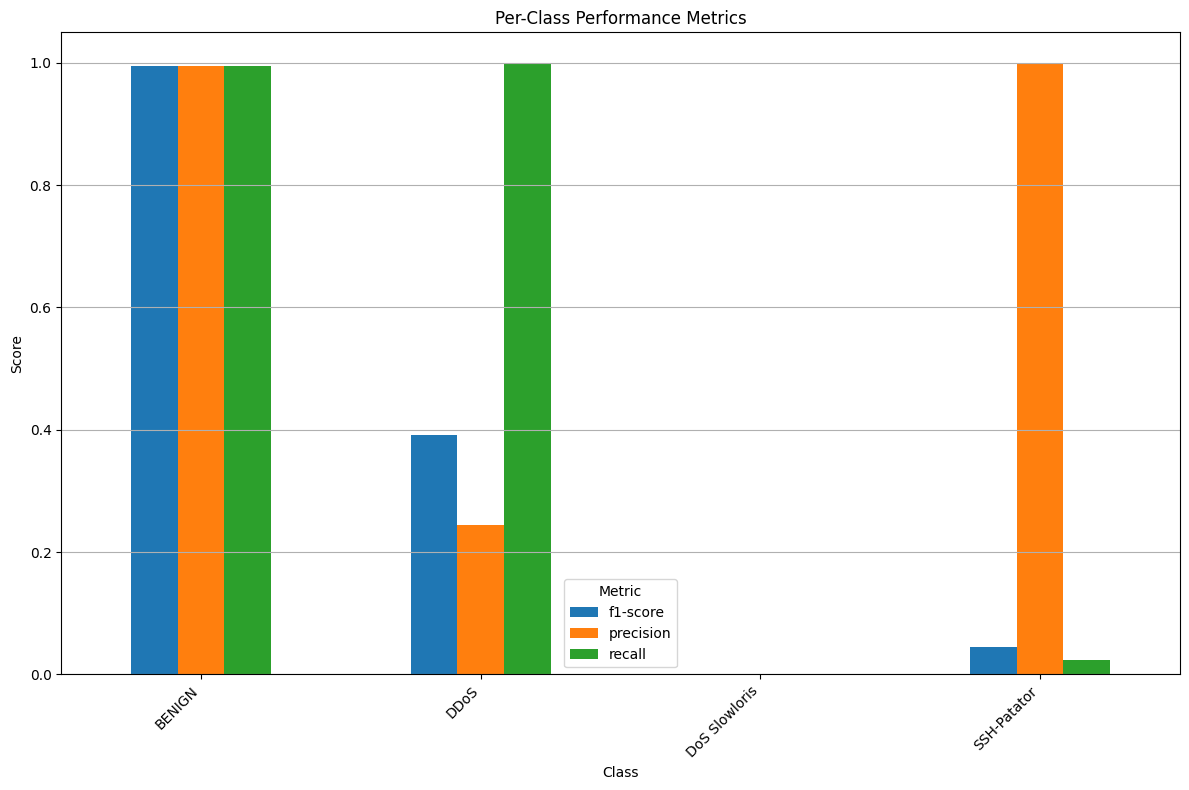

Model saved to: /content/network_attack_classifier_model.h5
Complete! Multi-class model has been trained for 1 epoch and saved to /content directory.
Checking for GPU availability...
TensorFlow version: 2.18.0
Num GPUs Available:  1
GPU is available and will be used
Mixed precision policy: mixed_float16
Setting paths to the specified locations...
Using embeddings file: /content/combined_embeddings.npy
Using metadata file: /content/combined_metadata.csv
✓ Embeddings file found at /content/combined_embeddings.npy
✓ Metadata file found at /content/combined_metadata.csv
Loading embeddings from /content/combined_embeddings.npy...
Loading metadata from /content/combined_metadata.csv...
Preparing for multi-class classification...
Loaded 18000 samples with 8192 features
Detected 23 unique classes: ['BENIGN' 'Botnet' 'Botnet - Attempted' 'DDoS' 'DoS GoldenEye'
 'DoS GoldenEye - Attempted' 'DoS Hulk' 'DoS Hulk - Attempted'
 'DoS Slowhttptest' 'DoS Slowhttptest - Attempted' 'DoS Slowloris'
 'DoS 

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_32 (Dense)                │ (None, 2048)           │    16,779,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 23)             │         2,967 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,907,735 (68.31 MB)

 Trainable params: 17,902,359 (68.29 MB)

 Non-trainable params: 5,376 (21.00 KB)

Training model...
Starting training with batch size 64 on GPU
Epoch 1/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7711 - loss: 1.0133
Epoch 1: val_loss improved from inf to 5.22516, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 70s 92ms/step - accuracy: 0.7720 - loss: 1.0095 - val_accuracy: 0.3454 - val_loss: 5.2252 - learning_rate: 0.0010
Epoch 2/30
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9832 - loss: 0.0874
Epoch 2: val_loss improved from 5.22516 to 0.54297, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9832 - loss: 0.0873 - val_accuracy: 0.9033 - val_loss: 0.5430 - learning_rate: 0.0010
Epoch 3/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9858 - loss: 0.0648
Epoch 3: val_loss improved from 0.54297 to 0.06638, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.9858 - loss: 0.0647 - val_accuracy: 0.9856 - val_loss: 0.0664 - learning_rate: 0.0010
Epoch 4/30
169/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9885 - loss: 0.0450
Epoch 4: val_loss did not improve from 0.06638
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.9885 - loss: 0.0451 - val_accuracy: 0.9783 - val_loss: 0.1426 - learning_rate: 0.0010
Epoch 5/30
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9899 - loss: 0.0410
Epoch 5: val_loss did not improve from 0.06638
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - accuracy: 0.9899 - loss: 0.0409 - val_accuracy: 0.9836 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 6/30
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9897 - loss: 0.0331
Epoch 6: val_loss did not improve from 0.06638
169/169 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.9897 - loss: 0.0331 - val_accuracy: 0.9614 - val_loss: 0.1110 - learning_rate: 0.0010
Epoch 7/30
166/169 ━━━━━━━━━━━

169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 41ms/step - accuracy: 0.9925 - loss: 0.0240 - val_accuracy: 0.9906 - val_loss: 0.0420 - learning_rate: 2.0000e-04
Epoch 8/30
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0178
Epoch 8: val_loss improved from 0.04197 to 0.02479, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 14s 81ms/step - accuracy: 0.9952 - loss: 0.0178 - val_accuracy: 0.9936 - val_loss: 0.0248 - learning_rate: 2.0000e-04
Epoch 9/30
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9961 - loss: 0.0139
Epoch 9: val_loss improved from 0.02479 to 0.02254, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - accuracy: 0.9961 - loss: 0.0139 - val_accuracy: 0.9944 - val_loss: 0.0225 - learning_rate: 2.0000e-04
Epoch 10/30
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9952 - loss: 0.0160
Epoch 10: val_loss improved from 0.02254 to 0.01802, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 74ms/step - accuracy: 0.9953 - loss: 0.0159 - val_accuracy: 0.9956 - val_loss: 0.0180 - learning_rate: 2.0000e-04
Epoch 11/30
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9958 - loss: 0.0125
Epoch 11: val_loss improved from 0.01802 to 0.01562, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - accuracy: 0.9958 - loss: 0.0125 - val_accuracy: 0.9961 - val_loss: 0.0156 - learning_rate: 2.0000e-04
Epoch 12/30
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9967 - loss: 0.0110
Epoch 12: val_loss did not improve from 0.01562
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.9966 - loss: 0.0110 - val_accuracy: 0.9928 - val_loss: 0.0305 - learning_rate: 2.0000e-04
Epoch 13/30
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9966 - loss: 0.0101
Epoch 13: val_loss did not improve from 0.01562
169/169 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.9966 - loss: 0.0102 - val_accuracy: 0.9956 - val_loss: 0.0174 - learning_rate: 2.0000e-04
Epoch 14/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9968 - loss: 0.0090
Epoch 14: val_loss improved from 0.01562 to 0.01302, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9968 - loss: 0.0090 - val_accuracy: 0.9964 - val_loss: 0.0130 - learning_rate: 2.0000e-04
Epoch 15/30
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0094
Epoch 15: val_loss did not improve from 0.01302
169/169 ━━━━━━━━━━━━━━━━━━━━ 7s 40ms/step - accuracy: 0.9972 - loss: 0.0094 - val_accuracy: 0.9925 - val_loss: 0.0326 - learning_rate: 2.0000e-04
Epoch 16/30
163/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9971 - loss: 0.0085
Epoch 16: val_loss improved from 0.01302 to 0.01220, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 12s 69ms/step - accuracy: 0.9971 - loss: 0.0085 - val_accuracy: 0.9969 - val_loss: 0.0122 - learning_rate: 2.0000e-04
Epoch 17/30
167/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9974 - loss: 0.0081
Epoch 17: val_loss did not improve from 0.01220
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 40ms/step - accuracy: 0.9974 - loss: 0.0081 - val_accuracy: 0.9931 - val_loss: 0.0348 - learning_rate: 2.0000e-04
Epoch 18/30
165/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9982 - loss: 0.0068
Epoch 18: val_loss improved from 0.01220 to 0.01124, saving model to /content/best_model_checkpoint.h5


169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 101ms/step - accuracy: 0.9982 - loss: 0.0069 - val_accuracy: 0.9964 - val_loss: 0.0112 - learning_rate: 2.0000e-04
Epoch 19/30
162/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9972 - loss: 0.0085
Epoch 19: val_loss did not improve from 0.01124
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 0.9939 - val_loss: 0.0269 - learning_rate: 2.0000e-04
Epoch 20/30
164/169 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9977 - loss: 0.0064
Epoch 20: val_loss did not improve from 0.01124
169/169 ━━━━━━━━━━━━━━━━━━━━ 11s 38ms/step - accuracy: 0.9977 - loss: 0.0064 - val_accuracy: 0.9964 - val_loss: 0.0160 - learning_rate: 2.0000e-04
Epoch 21/30
168/169 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9969 - loss: 0.0079
Epoch 21: val_loss did not improve from 0.01124
169/169 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.9969 - loss: 0.0079 - val_accuracy: 0.9925 - val_loss: 0.0339 - learning_rate: 2.0000e-04
Epoch 22

ValueError: Number of classes, 19, does not match size of target_names, 23. Try specifying the labels parameter

In [ ]:
# Network Attack Classification using Deep Learning
# GPU-accelerated on Google Colab - Multi-class Version

# Install any additional packages if needed
# !pip install -q tensorflow-gpu

# 1. Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import time
import os
# Import drive only if we need it
try:
    from google.colab import drive, files
    IN_COLAB = True
    print("Running in Google Colab")
except ImportError:
    IN_COLAB = False
    print("Not running in Google Colab")

# 2. Check for GPU availability
print("Checking for GPU availability...")
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available and will be used")
    # Set memory growth to avoid allocating all GPU memory at once
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision training for faster performance
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision policy:", policy.name)
else:
    print("No GPU available, using CPU instead")

# 3. Set the file paths to your specific locations
print("Setting paths to the specified locations...")
embeddings_path = './content/combined_embeddings.npy'
metadata_path = './content/combined_metadata.csv'  # Note: Changed from .npy to .csv based on your earlier output

print(f"Using embeddings file: {embeddings_path}")
print(f"Using metadata file: {metadata_path}")

# Check if files exist
if os.path.exists(embeddings_path):
    print(f"✓ Embeddings file found at {embeddings_path}")
else:
    print(f"❌ Warning: Embeddings file not found at {embeddings_path}")

if os.path.exists(metadata_path):
    print(f"✓ Metadata file found at {metadata_path}")
else:
    print(f"❌ Warning: Metadata file not found at {metadata_path}")

# 6. Load and prepare data
def load_data(embeddings_path, metadata_path):
    """Load embeddings and metadata files"""
    print(f"Loading embeddings from {embeddings_path}...")
    X = np.load(embeddings_path)

    print(f"Loading metadata from {metadata_path}...")
    metadata_df = pd.read_csv(metadata_path)

    # Encode labels for multi-class classification
    print("Preparing for multi-class classification...")
    le = LabelEncoder()
    metadata_df['encoded_label'] = le.fit_transform(metadata_df['label'])
    y = metadata_df['encoded_label'].values

    # Store the label encoder classes for later use
    label_classes = le.classes_
    num_classes = len(label_classes)

    print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
    print(f"Detected {num_classes} unique classes: {label_classes}")

    # Show distribution of classes
    class_counts = metadata_df['label'].value_counts()
    print("\nClass distribution:")
    for label, count in class_counts.items():
        print(f"  {label}: {count} samples ({count/len(metadata_df)*100:.2f}%)")

    return X, y, metadata_df, label_classes, num_classes

# 7. Create dataset splits
def create_dataset_splits(X, y, metadata_df, test_size=0.2, val_size=0.25):
    """Create train, validation, and test splits with handling for rare classes"""
    print("Creating dataset splits with special handling for rare classes...")

    # Get class counts
    class_counts = np.bincount(y)
    rare_classes = np.where(class_counts < 3)[0]

    if len(rare_classes) > 0:
        print(f"Found {len(rare_classes)} classes with fewer than 3 samples.")

        # Create a mask for rows with rare classes
        rare_mask = np.isin(y, rare_classes)
        rare_indices = np.where(rare_mask)[0]

        # Create a mask for rows with common classes
        common_mask = ~rare_mask
        common_indices = np.where(common_mask)[0]

        # Split common classes with stratification
        X_common = X[common_mask]
        y_common = y[common_mask]

        # First split: training+validation and test
        X_train_val_common, X_test_common, y_train_val_common, y_test_common = train_test_split(
            X_common, y_common, test_size=test_size, stratify=y_common, random_state=42
        )

        # Second split: training and validation
        X_train_common, X_val_common, y_train_common, y_val_common = train_test_split(
            X_train_val_common, y_train_val_common, test_size=val_size,
            stratify=y_train_val_common, random_state=42
        )

        # Handle rare classes - add them all to training set
        # This is a compromise but ensures we can train on these rare classes
        X_train_rare = X[rare_mask]
        y_train_rare = y[rare_mask]

        # Combine common and rare
        X_train = np.vstack([X_train_common, X_train_rare])
        y_train = np.concatenate([y_train_common, y_train_rare])
        X_val = X_val_common
        y_val = y_val_common
        X_test = X_test_common
        y_test = y_test_common

        # Record which rare classes were added to training set
        rare_class_names = [metadata_df['label'].unique()[cls_idx] for cls_idx in rare_classes]
        print(f"Rare classes added to training set: {rare_class_names}")

    else:
        # Standard split if no rare classes
        # First split: training+validation and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )

        # Second split: training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42
        )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

# 8. Build the model
def build_model(input_dim, num_classes, reduction_factor=4):
    """Build a neural network for multi-class classification"""
    # Calculate reduced dimension size
    reduced_dim = input_dim // reduction_factor

    model = Sequential([
        # First, reduce dimensions with a bottleneck layer
        Dense(reduced_dim, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),

        # Middle layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer for multi-class classification
        Dense(num_classes, activation='softmax')
    ])

    # Compile model with appropriate metrics for multi-class
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 9. Train the model
# 9. Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=1):  # Default changed to 1 epoch
    """Train the neural network model"""
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    # TensorBoard callback
    log_dir = "./content/logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )

    # Model checkpoint
    checkpoint_callback = ModelCheckpoint(
        './content/best_model_checkpoint.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Create TensorFlow Dataset for better GPU utilization
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Force epochs to be 1 regardless of what was passed in
    epochs = 1

    # Train the model
    print(f"Starting training with batch size {batch_size} on {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'}")
    print(f"Training for EXACTLY {epochs} epoch - early stopping is disabled for single-epoch training")
    start_time = time.time()

    # Remove callbacks for single-epoch training
    if epochs == 1:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            verbose=1
        )
    else:
        history = model.fit(
            train_ds,
            validation_data=val_ds,
            epochs=epochs,
            callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback],
            verbose=1
        )

    training_time = time.time() - start_time
    minutes, seconds = divmod(training_time, 60)
    print(f"Training completed in {int(minutes)} minutes and {seconds:.2f} seconds")

    return history

# 10. Evaluate the model
def evaluate_model(model, X_test, y_test, label_classes):
    """Evaluate the model on test data"""
    # Convert to TensorFlow Dataset for efficient processing
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

    # Get model evaluation on test dataset
    test_results = model.evaluate(test_ds, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(test_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)

    # Identify classes present in the test set
    unique_classes_in_test = np.unique(y_test)
    test_class_names = [label_classes[i] for i in unique_classes_in_test]

    print(f"\nTest set contains {len(unique_classes_in_test)} out of {len(label_classes)} classes")
    print(f"Classes in test set: {test_class_names}")

    # Generate classification report only for classes in the test set
    report = classification_report(y_test, y_pred, labels=unique_classes_in_test,
                                 target_names=test_class_names, output_dict=True)

    # Print the classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, labels=unique_classes_in_test,
                              target_names=test_class_names))

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    results = {
        'accuracy': acc,
        'classification_report': report,
        'confusion_matrix': cm,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred,
        'classes_in_test': unique_classes_in_test,
        'class_names_in_test': test_class_names
    }

    return results

# 11. Plot results
def plot_results(history, results, label_classes):
    """Plot training history and evaluation results"""
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('./content/network_attack_training_history.png')
    print("Training history saved to: ./content/network_attack_training_history.png")
    plt.show()

    # Plot confusion matrix - but limit to classes that appear in test set
    # Get unique classes in the test set
    unique_classes = np.unique(results['y_pred'])
    labels_in_test = [label_classes[i] for i in unique_classes]

    # Use a subset of the confusion matrix for better visualization
    num_classes_to_show = min(10, len(labels_in_test))
    top_classes_indices = unique_classes[:num_classes_to_show]
    top_classes = [label_classes[i] for i in top_classes_indices]

    # Create a smaller confusion matrix with just the top classes
    cm_subset = results['confusion_matrix'][np.ix_(top_classes_indices, top_classes_indices)]

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues',
                xticklabels=top_classes,
                yticklabels=top_classes)
    plt.title('Confusion Matrix (Top Classes)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.savefig('./content/network_attack_confusion_matrix.png')
    print("Confusion matrix saved to: ./content/network_attack_confusion_matrix.png")
    plt.show()

    # Plot per-class metrics for classes in the test set
    report = results['classification_report']

    # Extract class metrics from the report for classes that were actually in the test set
    metrics = ['precision', 'recall', 'f1-score']
    metrics_data = []

    for cls in labels_in_test:
        if cls in report:
            for metric in metrics:
                if metric in report[cls]:
                    metrics_data.append({
                        'class': cls,
                        'metric': metric,
                        'value': report[cls][metric]
                    })

    if metrics_data:
        metrics_df = pd.DataFrame(metrics_data)

        # Pivot the dataframe for easier plotting
        metrics_pivot = metrics_df.pivot(index='class', columns='metric', values='value')

        # Plot the metrics
        plt.figure(figsize=(12, 8))
        metrics_pivot.plot(kind='bar', figsize=(12, 8))
        plt.title('Per-Class Performance Metrics')
        plt.ylabel('Score')
        plt.xlabel('Class')
        plt.xticks(rotation=45, ha='right')
        plt.grid(axis='y')
        plt.legend(title='Metric')

        plt.tight_layout()
        plt.savefig('./content/network_attack_class_metrics.png')
        print("Per-class metrics saved to: ./content/network_attack_class_metrics.png")
        plt.show()

# 12. Save model
def save_model(model, path='./content/network_attack_classifier_model.h5'):
    """Save the trained model to the content directory"""
    model.save(path)
    print(f"Model saved to: {path}")

# 13. Main execution - with fixed epochs=1
# Load data
X, y, metadata_df, label_classes, num_classes = load_data(embeddings_path, metadata_path)

# Create dataset splits with rare class handling
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset_splits(X, y, metadata_df)

# Build the model
print("Building multi-class model...")
model = build_model(input_dim=X.shape[1], num_classes=num_classes)
model.summary()

# Train the model for EXACTLY 1 epoch - hard-coded
print("Training model for EXACTLY 1 epoch...")
history = train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=1)

# Evaluate the model
print("Evaluating model...")
results = evaluate_model(model, X_test, y_test, label_classes)

# Plot results
plot_results(history, results, label_classes)

# Save the model
save_model(model)

print("Complete! Multi-class model has been trained for 1 epoch and saved to ./content directory.")

# 2. Check for GPU availability
print("Checking for GPU availability...")
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available and will be used")
    # Set memory growth to avoid allocating all GPU memory at once
    gpus = tf.config.list_physical_devices('GPU')
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

    # Enable mixed precision training for faster performance
    policy = tf.keras.mixed_precision.Policy('mixed_float16')
    tf.keras.mixed_precision.set_global_policy(policy)
    print("Mixed precision policy:", policy.name)
else:
    print("No GPU available, using CPU instead")

# 3. Mount Google Drive (optional - commented out as we're working in /content)
# print("Mounting Google Drive...")
# drive.mount('/content/drive')

# 4. Set the file paths to your specific locations
print("Setting paths to the specified locations...")
embeddings_path = 'finetuned-embeddings-1_1-splits/combined_embeddings.npy'
metadata_path = 'finetuned-embeddings-1_1-splits/combined_metadata.csv'  # Note: Changed from .npy to .csv based on your earlier output

print(f"Using embeddings file: {embeddings_path}")
print(f"Using metadata file: {metadata_path}")

# Check if files exist
if os.path.exists(embeddings_path):
    print(f"✓ Embeddings file found at {embeddings_path}")
else:
    print(f"❌ Warning: Embeddings file not found at {embeddings_path}")

if os.path.exists(metadata_path):
    print(f"✓ Metadata file found at {metadata_path}")
else:
    print(f"❌ Warning: Metadata file not found at {metadata_path}")


# 6. Load and prepare data
def load_data(embeddings_path, metadata_path):
    """Load embeddings and metadata files"""
    print(f"Loading embeddings from {embeddings_path}...")
    X = np.load(embeddings_path)

    print(f"Loading metadata from {metadata_path}...")
    metadata_df = pd.read_csv(metadata_path)

    # Encode labels for multi-class classification
    print("Preparing for multi-class classification...")
    le = LabelEncoder()
    metadata_df['encoded_label'] = le.fit_transform(metadata_df['label'])
    y = metadata_df['encoded_label'].values

    # Store the label encoder classes for later use
    label_classes = le.classes_
    num_classes = len(label_classes)

    print(f"Loaded {X.shape[0]} samples with {X.shape[1]} features")
    print(f"Detected {num_classes} unique classes: {label_classes}")

    # Show distribution of classes
    class_counts = metadata_df['label'].value_counts()
    print("\nClass distribution:")
    for label, count in class_counts.items():
        print(f"  {label}: {count} samples ({count/len(metadata_df)*100:.2f}%)")

    return X, y, metadata_df, label_classes, num_classes

# 7. Create dataset splits
def create_dataset_splits(X, y, metadata_df, test_size=0.2, val_size=0.25):
    """Create train, validation, and test splits with handling for rare classes"""
    print("Creating dataset splits with special handling for rare classes...")

    # Get class counts
    class_counts = np.bincount(y)
    rare_classes = np.where(class_counts < 3)[0]

    if len(rare_classes) > 0:
        print(f"Found {len(rare_classes)} classes with fewer than 3 samples.")

        # Create a mask for rows with rare classes
        rare_mask = np.isin(y, rare_classes)
        rare_indices = np.where(rare_mask)[0]

        # Create a mask for rows with common classes
        common_mask = ~rare_mask
        common_indices = np.where(common_mask)[0]

        # Split common classes with stratification
        X_common = X[common_mask]
        y_common = y[common_mask]

        # First split: training+validation and test
        X_train_val_common, X_test_common, y_train_val_common, y_test_common = train_test_split(
            X_common, y_common, test_size=test_size, stratify=y_common, random_state=42
        )

        # Second split: training and validation
        X_train_common, X_val_common, y_train_common, y_val_common = train_test_split(
            X_train_val_common, y_train_val_common, test_size=val_size,
            stratify=y_train_val_common, random_state=42
        )

        # Handle rare classes - add them all to training set
        # This is a compromise but ensures we can train on these rare classes
        X_train_rare = X[rare_mask]
        y_train_rare = y[rare_mask]

        # Combine common and rare
        X_train = np.vstack([X_train_common, X_train_rare])
        y_train = np.concatenate([y_train_common, y_train_rare])
        X_val = X_val_common
        y_val = y_val_common
        X_test = X_test_common
        y_test = y_test_common

        # Record which rare classes were added to training set
        rare_class_names = [metadata_df['label'].iloc[i] for i in rare_indices]
        print(f"Rare classes added to training set: {rare_class_names}")

    else:
        # Standard split if no rare classes
        # First split: training+validation and test
        X_train_val, X_test, y_train_val, y_test = train_test_split(
            X, y, test_size=test_size, stratify=y, random_state=42
        )

        # Second split: training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val, test_size=val_size, stratify=y_train_val, random_state=42
        )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")

    return X_train, X_val, X_test, y_train, y_val, y_test

# 8. Build the model
def build_model(input_dim, num_classes, reduction_factor=4):
    """Build a neural network for multi-class classification"""
    # Calculate reduced dimension size
    reduced_dim = input_dim // reduction_factor

    model = Sequential([
        # First, reduce dimensions with a bottleneck layer
        Dense(reduced_dim, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.5),

        # Middle layers
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),

        # Output layer for multi-class classification
        Dense(num_classes, activation='softmax')
    ])

    # Compile model with appropriate metrics for multi-class
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# 9. Train the model
def train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=30):
    """Train the neural network model"""
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6
    )

    # TensorBoard callback
    log_dir = "./content/logs/fit/" + time.strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = TensorBoard(
        log_dir=log_dir,
        histogram_freq=1,
        write_graph=True
    )

    # Model checkpoint
    checkpoint_callback = ModelCheckpoint(
        './content/best_model_checkpoint.h5',
        monitor='val_loss',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    # Create TensorFlow Dataset for better GPU utilization
    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

    # Train the model
    print(f"Starting training with batch size {batch_size} on {'GPU' if len(tf.config.list_physical_devices('GPU')) > 0 else 'CPU'}")
    start_time = time.time()

    history = model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=epochs,
        callbacks=[early_stopping, reduce_lr, tensorboard_callback, checkpoint_callback],
        verbose=1
    )

    training_time = time.time() - start_time
    minutes, seconds = divmod(training_time, 60)
    print(f"Training completed in {int(minutes)} minutes and {seconds:.2f} seconds")

    return history

# 10. Evaluate the model
def evaluate_model(model, X_test, y_test, label_classes):
    """Evaluate the model on test data"""
    # Convert to TensorFlow Dataset for efficient processing
    test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(64).prefetch(tf.data.AUTOTUNE)

    # Get model evaluation on test dataset
    test_results = model.evaluate(test_ds, verbose=1)
    print(f"Test loss: {test_results[0]:.4f}")
    print(f"Test accuracy: {test_results[1]:.4f}")

    # Get predictions
    y_pred_prob = model.predict(test_ds)
    y_pred = np.argmax(y_pred_prob, axis=1)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, target_names=label_classes, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)

    print(f"Test accuracy: {acc:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=label_classes))

    results = {
        'accuracy': acc,
        'classification_report': report,
        'confusion_matrix': cm,
        'y_pred_prob': y_pred_prob,
        'y_pred': y_pred
    }

    return results

# 11. Plot results
def plot_results(history, results, label_classes):
    """Plot training history and evaluation results"""
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    plt.grid(True)

    # Plot training & validation loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('./content/network_attack_training_history.png')
    print("Training history saved to: ./content/network_attack_training_history.png")
    plt.show()

    # Plot confusion matrix
    plt.figure(figsize=(14, 12))
    cm = results['confusion_matrix']

    # Normalize confusion matrix for better visualization
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot confusion matrix
    plt.figure(figsize=(14, 12))
    sns.heatmap(cm_norm, annot=cm, fmt='d', cmap='Blues',
                xticklabels=label_classes,
                yticklabels=label_classes)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)

    plt.tight_layout()
    plt.savefig('./content/network_attack_confusion_matrix.png')
    print("Confusion matrix saved to: ./content/network_attack_confusion_matrix.png")
    plt.show()

    # Plot per-class metrics
    report = results['classification_report']

    # Extract class metrics from the report
    classes = list(label_classes)
    metrics = ['precision', 'recall', 'f1-score']

    # Create a dataframe for plotting
    metrics_data = []
    for cls in classes:
        if cls in report:
            for metric in metrics:
                metrics_data.append({
                    'class': cls,
                    'metric': metric,
                    'value': report[cls][metric]
                })

    metrics_df = pd.DataFrame(metrics_data)

    # Pivot the dataframe for easier plotting
    metrics_pivot = metrics_df.pivot(index='class', columns='metric', values='value')

    # Plot the metrics
    plt.figure(figsize=(12, 8))
    metrics_pivot.plot(kind='bar', figsize=(12, 8))
    plt.title('Per-Class Performance Metrics')
    plt.ylabel('Score')
    plt.xlabel('Class')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    plt.legend(title='Metric')

    plt.tight_layout()
    plt.savefig('./content/network_attack_class_metrics.png')
    print("Per-class metrics saved to: ./content/network_attack_class_metrics.png")
    plt.show()

# 12. Save model
def save_model(model, path='./content/network_attack_classifier_model.h5'):
    """Save the trained model to the content directory"""
    model.save(path)
    print(f"Model saved to: {path}")

# 13. Main execution
# Load data
X, y, metadata_df, label_classes, num_classes = load_data(embeddings_path, metadata_path)

# Create dataset splits with rare class handling
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset_splits(X, y, metadata_df)

# Build the model
print("Building multi-class model...")
model = build_model(input_dim=X.shape[1], num_classes=num_classes)
model.summary()

# Train the model
print("Training model...")
history = train_model(model, X_train, y_train, X_val, y_val, batch_size=64, epochs=30)

# Evaluate the model
print("Evaluating model...")
results = evaluate_model(model, X_test, y_test, label_classes)

# Plot results
plot_results(history, results, label_classes)

# Save the model
save_model(model)

print("Complete! Multi-class model has been trained, evaluated, and saved to ./content directory.")

# 14. Optional: Analyze model performance on specific attack types
print("\nAnalyzing detailed performance by attack type...")

# Get predictions for all data
y_pred_prob = model.predict(X)
y_pred = np.argmax(y_pred_prob, axis=1)

# Merge predictions with original metadata
metadata_df['predicted_class'] = y_pred
metadata_df['correct'] = (metadata_df['encoded_label'] == metadata_df['predicted_class']).astype(int)

# Calculate accuracy per attack type
label_accuracy = metadata_df.groupby('label').apply(
    lambda x: accuracy_score(x['encoded_label'], x['predicted_class'])
).sort_values()

print("\nAccuracy by attack type:")
for label, acc in label_accuracy.items():
    print(f"{label}: {acc:.4f}")

# Create visualization of performance by attack type
plt.figure(figsize=(12, 8))
label_accuracy.plot(kind='bar')
plt.title('Model Accuracy by Attack Type')
plt.ylabel('Accuracy')
plt.xlabel('Attack Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.grid(axis='y')
plt.savefig('./content/accuracy_by_attack_type.png')
print("Attack type analysis saved to: ./content/accuracy_by_attack_type.png")
plt.show()

# Confusion matrix for specific classes
print("\nCreating detailed confusion matrices...")

# Create a confusion matrix for the top attack types (most frequent ones)
top_attacks = metadata_df['label'].value_counts().nlargest(5).index.tolist()
if 'BENIGN' not in top_attacks:
    top_attacks.append('BENIGN')  # Always include BENIGN

# Filter data for top attacks
top_attacks_df = metadata_df[metadata_df['label'].isin(top_attacks)]
top_y_true = top_attacks_df['encoded_label'].values
top_y_pred = top_attacks_df['predicted_class'].values

# Get the corresponding class indices
top_indices = [list(label_classes).index(label) for label in top_attacks]

# Create confusion matrix
cm_top = confusion_matrix(top_y_true, top_y_pred)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_top, annot=True, fmt='d', cmap='Blues',
            xticklabels=top_attacks,
            yticklabels=top_attacks)
plt.title('Confusion Matrix for Most Common Attack Types')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./content/top_attacks_confusion_matrix.png')
print("Top attacks confusion matrix saved to: ./content/top_attacks_confusion_matrix.png")
plt.show()

